In [1]:
import sys
sys.path.append('./simulator_exhaustion/')
from simulator import *


from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
import os
from collections import defaultdict
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000  

3630 total jobs
3630 = 11 × 11 × 3 × 10, which very naturally fits:
- 11 values for omega_zero
- 11 values for delta
- 3 values for epsilon
- 10 replicates per parameter combo

---

```python
omega_zero_list = np.round(np.linspace(0.5, 1.0, 11), 2)
delta_list = np.round(np.linspace(0.25, 1.0, 11), 2)
epsilonKT_list = np.round(np.linspace(250, 500, 3), 0)
replicate_sequence_list = range(10)
```

```text
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.25 0.32 0.4  0.48 0.55 0.62 0.7  0.78 0.85 0.92 1.  ]
[250. 375. 500.]
range(0, 10)
```

Filename: e.g. omg0-0.25_del-0.45_eps-200_rep-7.

In [2]:
data_dir = Path("./ABM_results/output")
eps_values = [250., 375., 500.]

def iter_files_for_epsilon(eps_value, replicates=None):
    for f in data_dir.glob(f"*eps-{eps_value}_*.parquet"):
        if replicates is not None:
            rep_strs = [f"rep-{r}" for r in replicates]
            if not any(rep in f.name for rep in rep_strs):
                continue
        yield f

def read_with_metadata(file_path):
    df = pd.read_parquet(file_path)
    parts = file_path.stem.split("_")
    for p in parts:
        if "-" in p:
            k, v = p.split("-")
            try:
                df[k] = float(v)
            except ValueError:
                df[k] = v
    return df

def load_epsilon(eps_value, replicates=None, chunk_size=100):
    buf = []
    for i, f in enumerate(iter_files_for_epsilon(eps_value, replicates), start=1):
        df = read_with_metadata(f)
        buf.append(df)
        if i % chunk_size == 0:
            yield pd.concat(buf, ignore_index=True)
            buf = []
    if buf:
        yield pd.concat(buf, ignore_index=True)


In [3]:
eps = 375
replicates_to_load = [0, 1, 2]
chunks = []
for chunk in load_epsilon(eps, replicates=replicates_to_load):
    chunks.append(chunk)

df_eps = pd.concat(chunks, ignore_index=True)
df_eps.head()

step  time cell_type  cell_id           x           y  mu_x  mu_y  \
0     0   0.0    killer        0 -320.354284  443.726062   0.0   0.0   
1     0   0.0    killer        1 -249.392006   88.318883   0.0   0.0   
2     0   0.0    killer        2   75.157695 -535.582909   0.0   0.0   
3     0   0.0    killer        3  366.481483 -465.957010   0.0   0.0   
4     0   0.0    killer        4  282.949165  183.356396   0.0   0.0   

   cell_state  alive_status  killing_P contacts  Death_Factor killed_by  omg0  \
0         0.5          True        1.0       []           NaN      None   0.5   
1         0.5          True        1.0       []           NaN      None   0.5   
2         0.5          True        1.0       []           NaN      None   0.5   
3         0.5          True        1.0       []           NaN      None   0.5   
4         0.5          True        1.0       []           NaN      None   0.5   

   del    eps  rep  
0  0.7  375.0  1.0  
1  0.7  375.0  1.0  
2  0.7  375.0  1.0  
3  0.7  375.0  1.0  
4  0.7  375.0  1.0

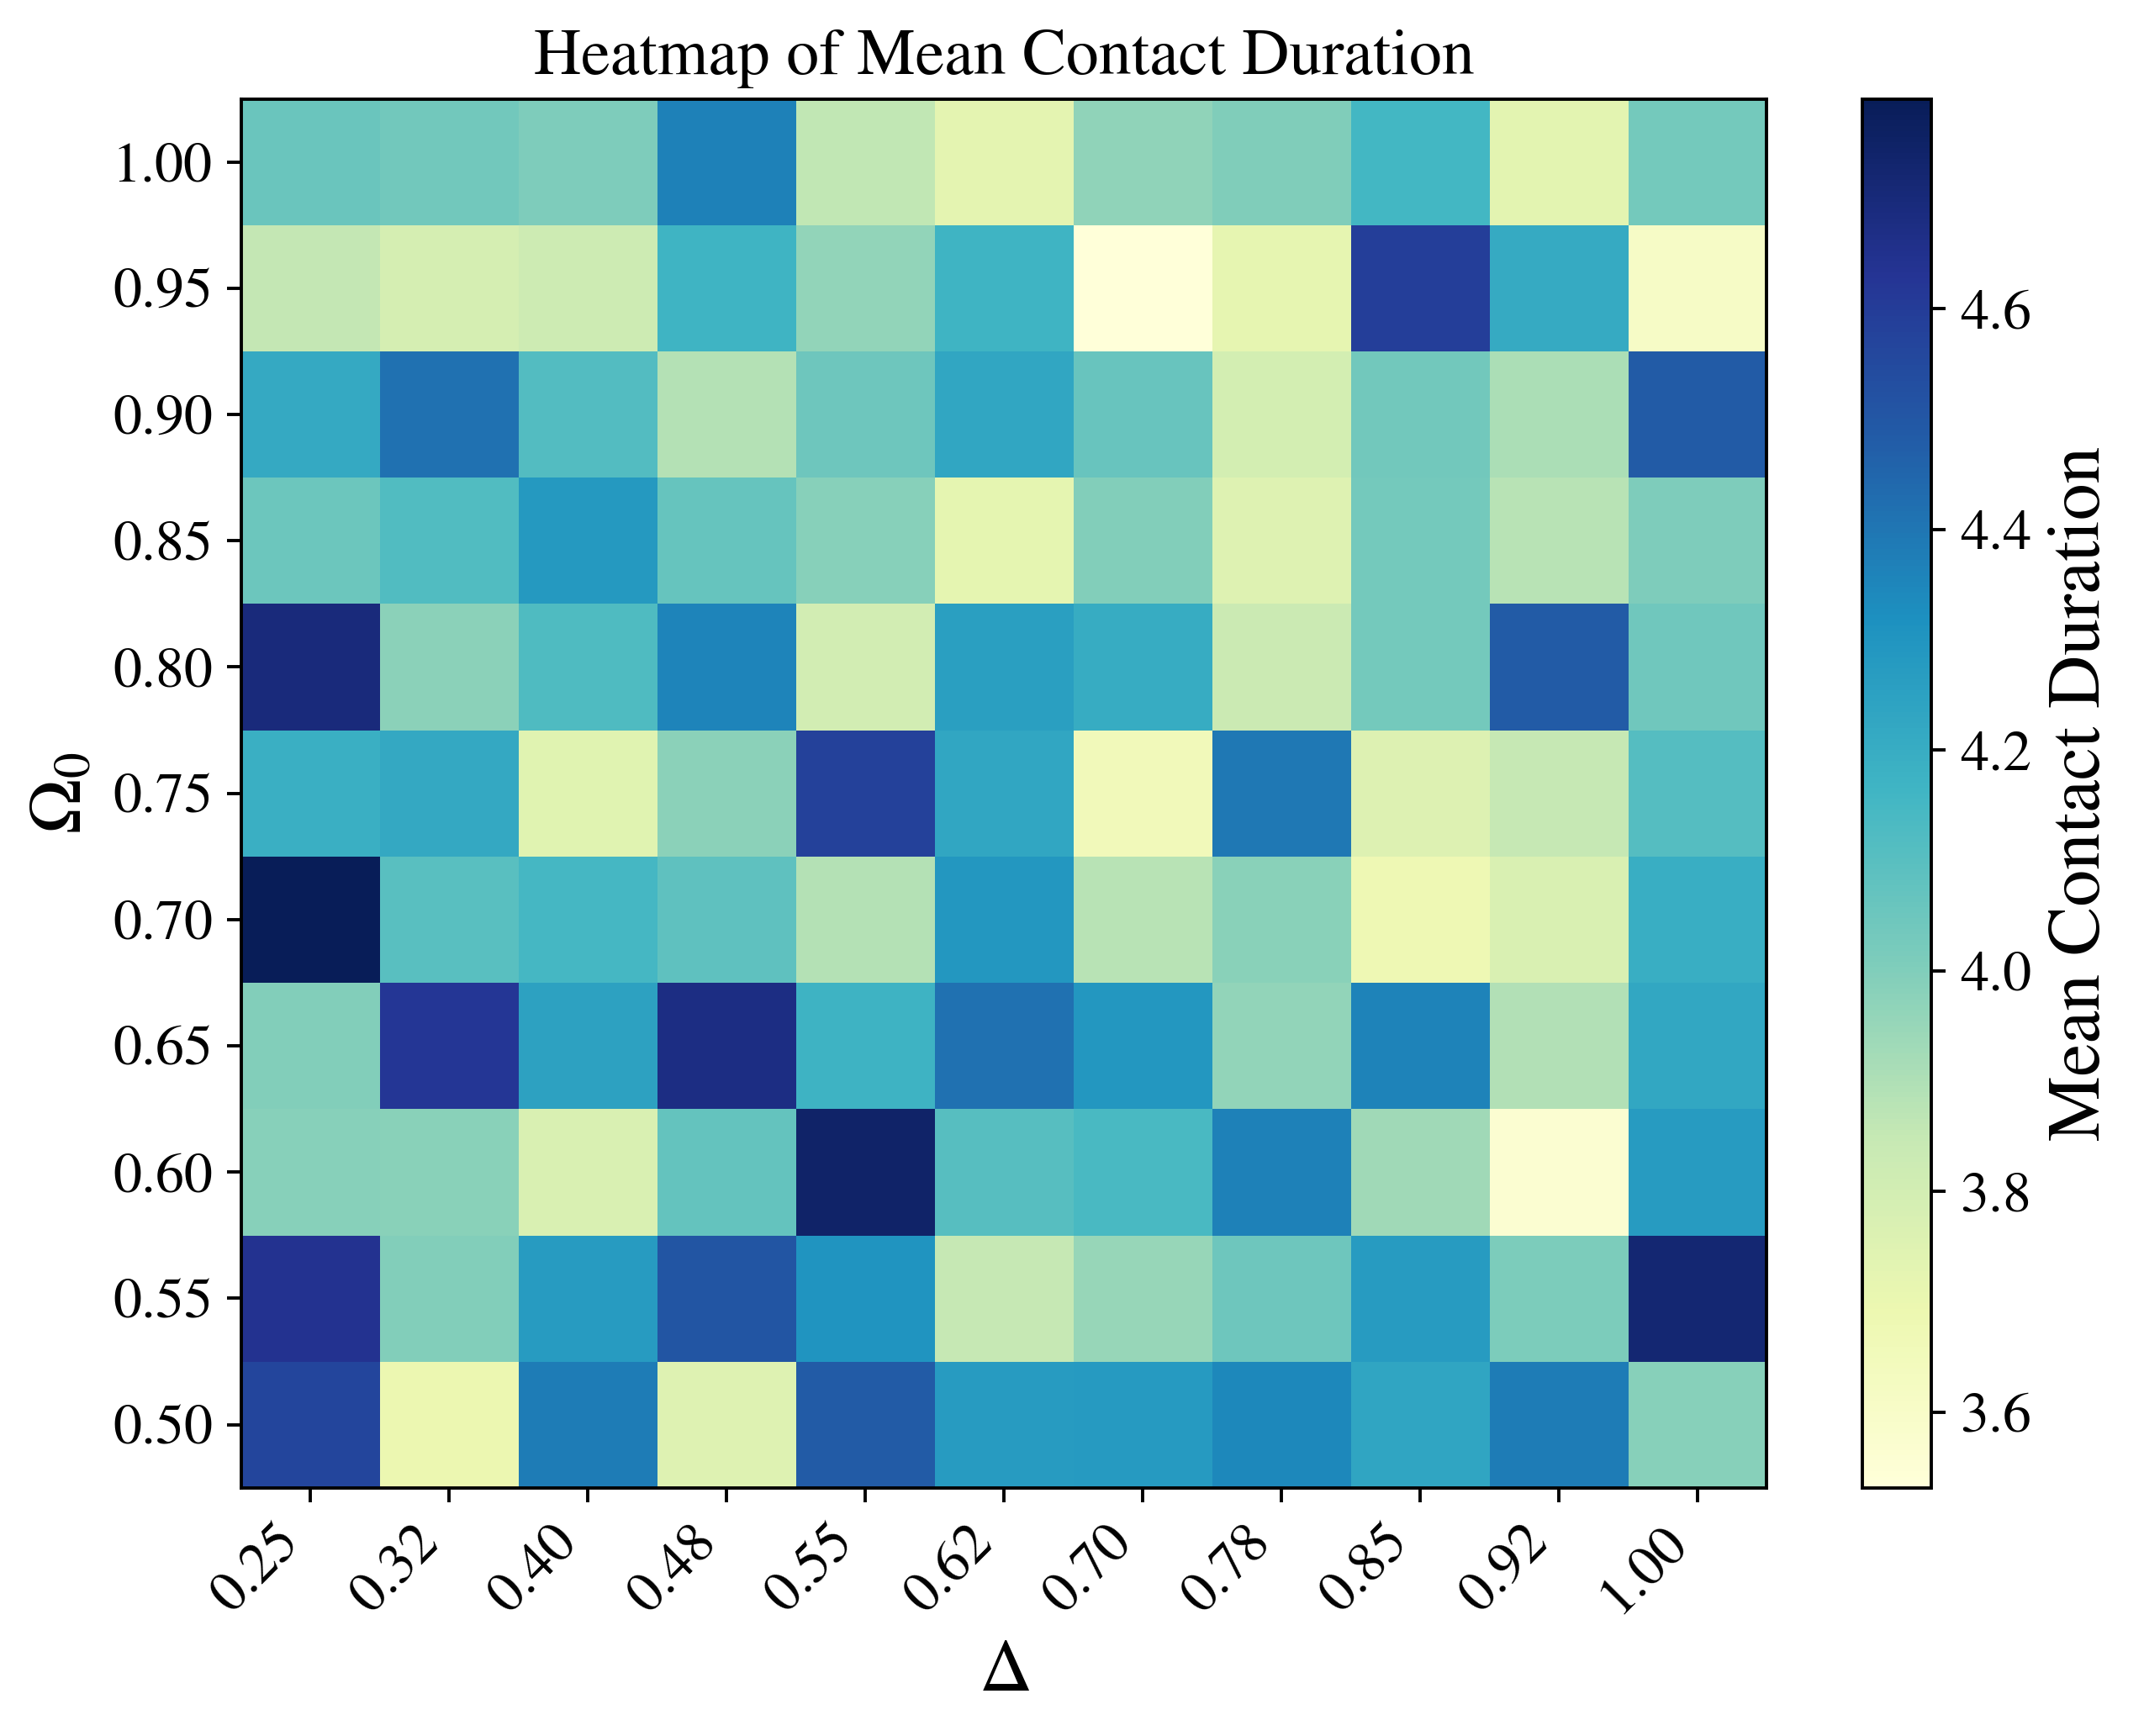

In [4]:
def _parse_contacts(x):
    import json
    if isinstance(x, (list, tuple, np.ndarray)): return list(x)
    if isinstance(x, str):
        s = x.strip()
        if not s or s == "[]": return []
        try:
            v = json.loads(s)
            return v if isinstance(v, list) else [v]
        except Exception:
            return []
    return [] if pd.isna(x) else [x]

def mean_contact_duration_heatmap(df):
    df = df.copy()
    df["contacts"] = df["contacts"].map(_parse_contacts)
    df = df.query("cell_type == 'killer'")
    df = df.sort_values(["omg0","del","rep","cell_id","time","step"], kind="mergesort")
    df["_gidx"] = df.groupby(["omg0","del","rep","cell_id"]).cumcount().astype(int)

    if not df["contacts"].map(bool).any():
        print("No contacts found.")
        return pd.DataFrame(), None

    mask = df["contacts"].map(bool).to_numpy()
    lens = np.fromiter((len(c) for c in df.loc[mask,"contacts"]), int)
    base_idx = np.repeat(np.flatnonzero(mask), lens)
    targets = np.concatenate([np.asarray(c, dtype=int) for c in df.loc[mask,"contacts"]])

    take = lambda col: col.to_numpy()[base_idx]
    ex = pd.DataFrame({
        "omg0": take(df["omg0"]),
        "del": take(df["del"]),
        "rep": take(df["rep"]),
        "cell_id": take(df["cell_id"]),
        "target_id": targets,
        "_gidx": take(df["_gidx"]),
        "time": take(df["time"]),
    })

    ex = ex.sort_values(["omg0","del","rep","cell_id","target_id","_gidx"], kind="mergesort")

    grp_cols = ["omg0","del","rep","cell_id","target_id"]
    ex["break"] = ex.groupby(grp_cols)["_gidx"].diff().ne(1)
    ex["run"] = ex.groupby(grp_cols)["break"].cumsum().astype(int)

    runs = ex.groupby(grp_cols + ["run"]).agg(start_idx=("_gidx","min"), end_idx=("_gidx","max")).reset_index()

    # time lookup as plain frame (avoid MultiIndex loc)
    time_tbl = df[["omg0","del","rep","cell_id","_gidx","time"]]

    # start times
    runs = runs.merge(time_tbl, how="left",
                      left_on=["omg0","del","rep","cell_id","start_idx"],
                      right_on=["omg0","del","rep","cell_id","_gidx"]) \
               .rename(columns={"time":"start_time"}).drop(columns="_gidx")

    # compute safe end index per killer
    last_idx = df.groupby(["omg0","del","rep","cell_id"], as_index=False)["_gidx"].max().rename(columns={"_gidx":"last_idx"})
    runs = runs.merge(last_idx, on=["omg0","del","rep","cell_id"], how="left")
    runs["end_idx_plus"] = np.minimum(runs["end_idx"] + 1, runs["last_idx"])

    # end times
    runs = runs.merge(time_tbl, how="left",
                      left_on=["omg0","del","rep","cell_id","end_idx_plus"],
                      right_on=["omg0","del","rep","cell_id","_gidx"]) \
               .rename(columns={"time":"end_time"}).drop(columns="_gidx")

    runs["duration"] = (runs["end_time"] - runs["start_time"]).astype(float)

    df_mean = runs.groupby(["omg0","del"], as_index=False)["duration"].mean()
    grid = df[["omg0","del"]].drop_duplicates()
    df_mean = grid.merge(df_mean, how="left", on=["omg0","del"])

    df_heat = df_mean.pivot(index="omg0", columns="del", values="duration").sort_index().sort_index(axis=1)
    return df_mean, df_heat

# ---- Run it on your data ----
df_mean, df_heat = mean_contact_duration_heatmap(df_eps)

fig, ax = plt.subplots(figsize=(7.5,6), dpi=350)
im = ax.imshow(df_heat.values, origin="lower", aspect="auto", interpolation="nearest", cmap="YlGnBu")
ax.set_xticks(np.arange(df_heat.shape[1]))
ax.set_xticklabels([f"{c:.2f}" for c in df_heat.columns], rotation=45, ha="right")
ax.set_yticks(np.arange(df_heat.shape[0]))
ax.set_yticklabels([f"{r:.2f}" for r in df_heat.index])
ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\Omega_{0}$")
ax.set_title("Heatmap of Mean Contact Duration")
fig.colorbar(im, ax=ax, label="Mean Contact Duration")
plt.tight_layout()
plt.show()

grid:   0%|          | 0/121 [00:00<?, ?it/s]

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_8575/2942332726.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


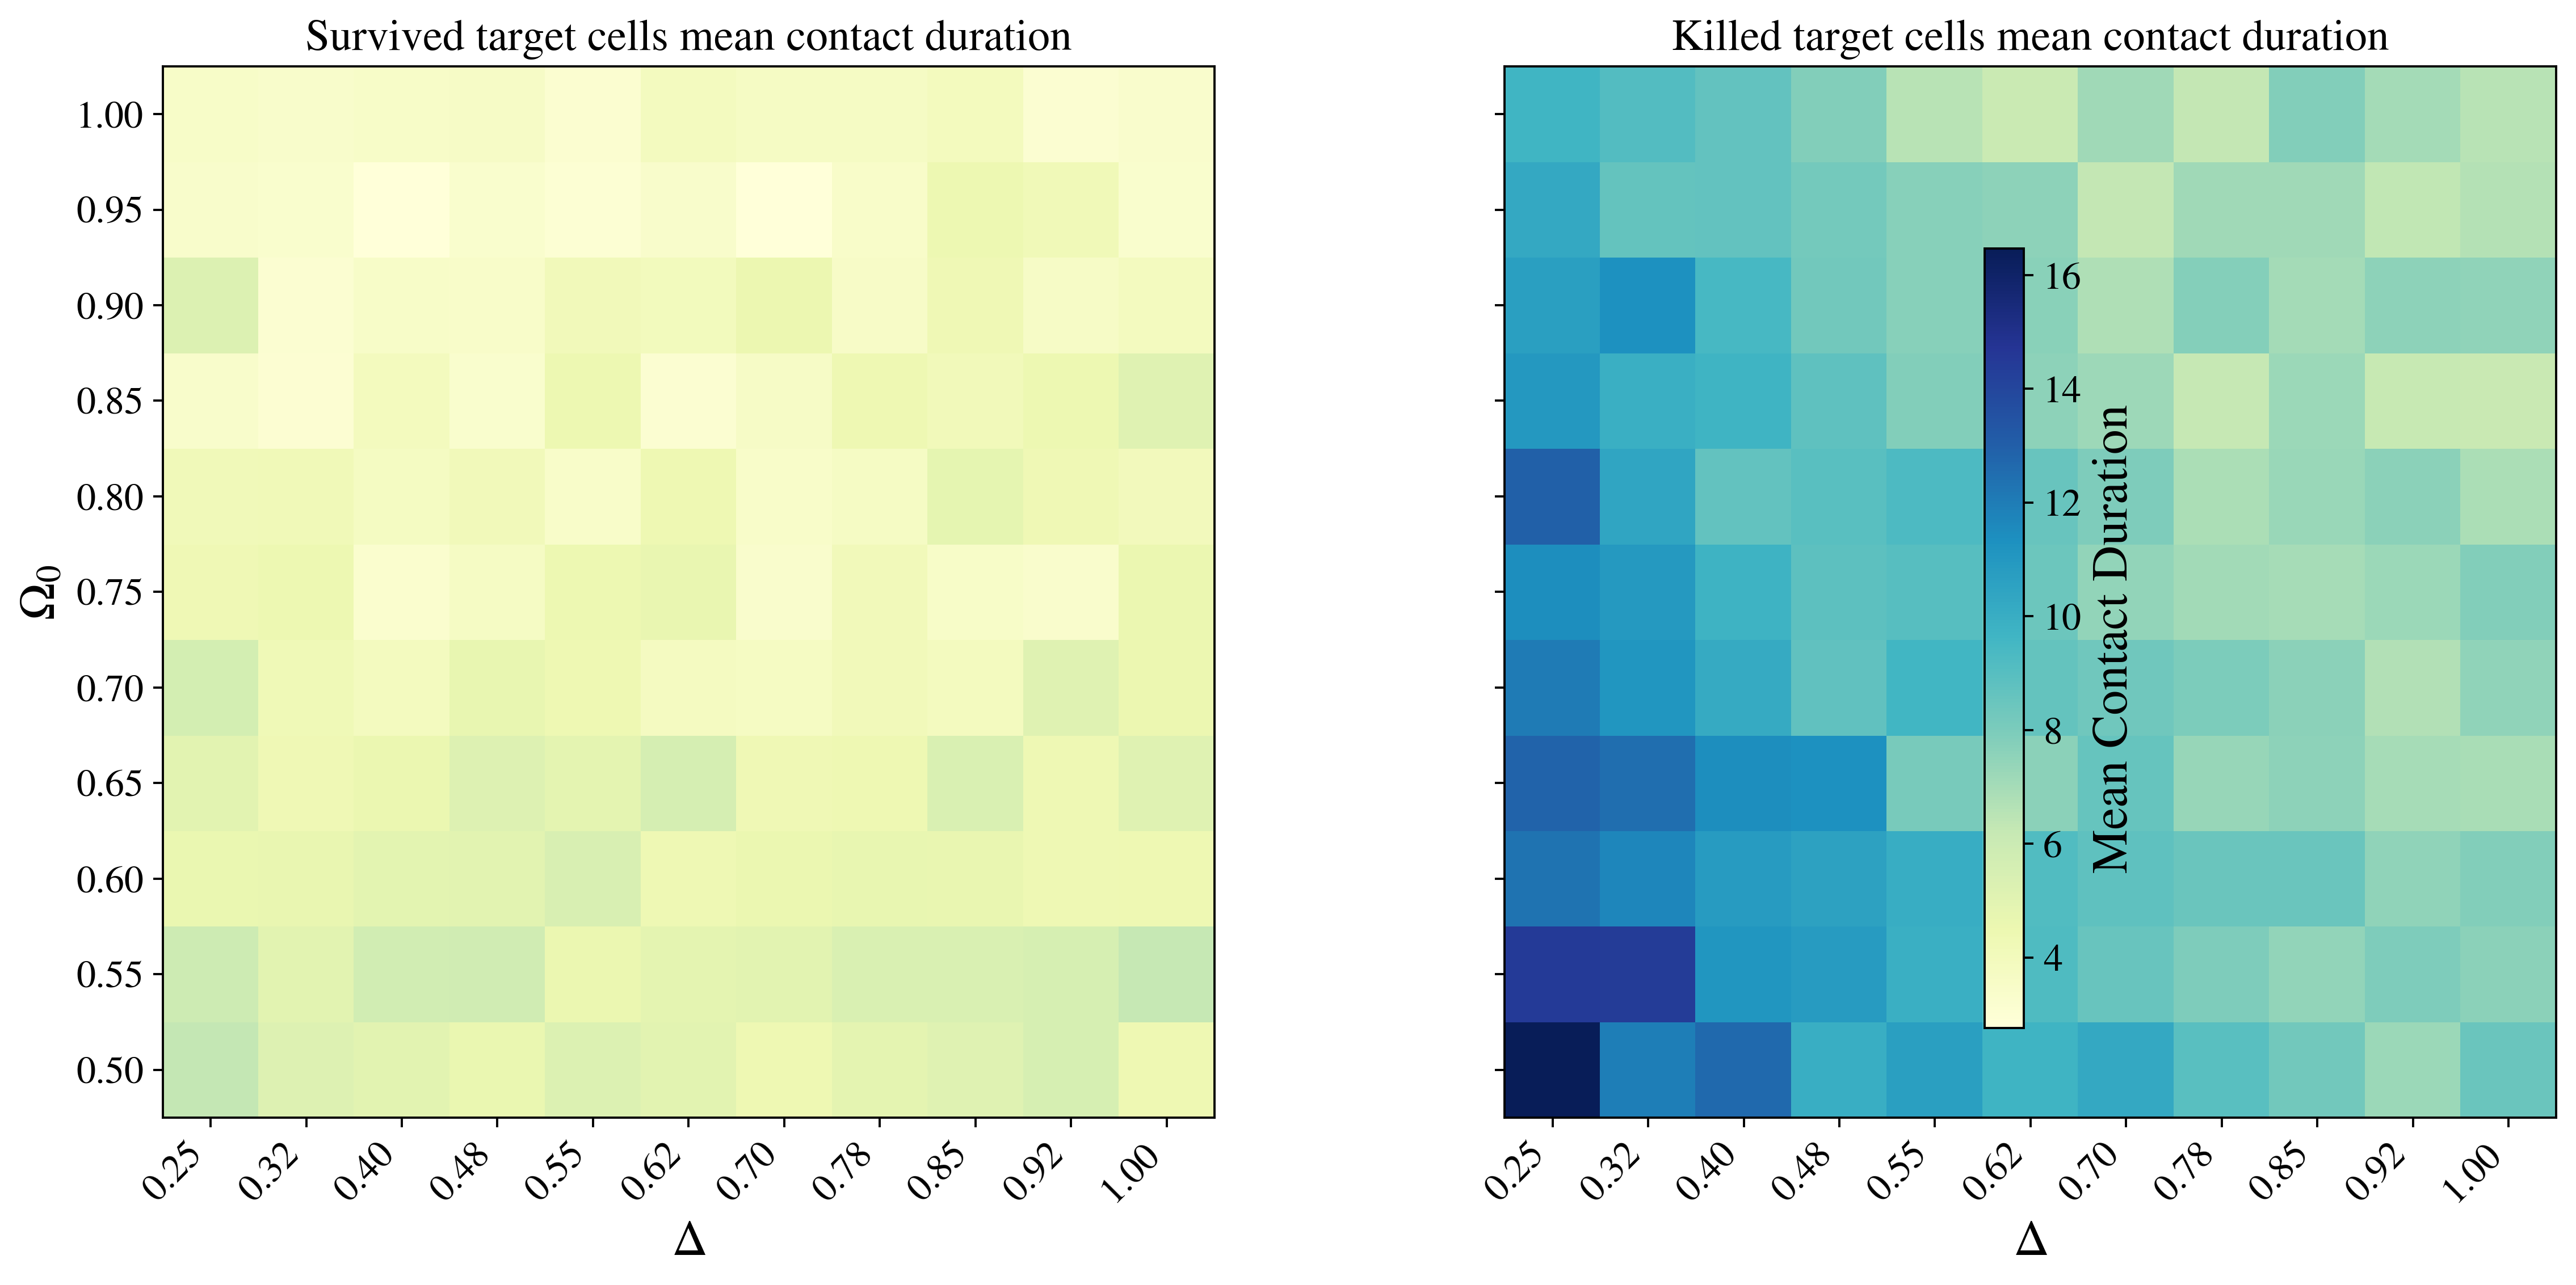

In [ ]:
def _parse_contacts(x):
    import json
    if isinstance(x, (list, tuple, np.ndarray)): return list(x)
    if isinstance(x, str):
        s = x.strip()
        if not s or s in ("[]", "nan", "NaN"): return []
        try:
            v = json.loads(s)
            return v if isinstance(v, list) else [v]
        except Exception:
            return []
    return [] if pd.isna(x) else [x]

def _contact_active(x):
    if isinstance(x, (list, tuple, np.ndarray)): return bool(x)
    if isinstance(x, str):
        s = x.strip().lower()
        if not s or s in ("[]", "nan"): return False
        try:
            v = json.loads(s)
            return bool(v)
        except Exception:
            return False
    return bool(x)

def _total_contact_time(subdf):
    subdf = subdf.sort_values("time")
    in_contact = subdf["contacts"].apply(_contact_active).to_numpy(dtype=bool)
    if not in_contact.any():
        return 0.0
    t = subdf["time"].to_numpy(dtype=float)
    diff = np.diff(in_contact.astype(int), prepend=0, append=0)
    starts = np.flatnonzero(diff == 1)
    ends = np.flatnonzero(diff == -1)
    return float(np.sum(t[np.minimum(ends, len(t)-1)] - t[starts]))

def _mean_durations_one_rep(rep_df):
    tgt = rep_df.loc[rep_df["cell_type"] == "target"]
    if tgt.empty:
        return np.nan, np.nan
    last = tgt.sort_values("time").groupby("cell_id", sort=False).tail(1)
    dead = set(last.loc[~last["alive_status"].astype(bool), "cell_id"])
    alive = set(last.loc[last["alive_status"].astype(bool), "cell_id"])
    lethal, nonlethal = [], []
    for cid, sub in tgt.groupby("cell_id", sort=False):
        dur = _total_contact_time(sub)
        if cid in dead: lethal.append(dur)
        elif cid in alive: nonlethal.append(dur)
    mL = np.nanmean(lethal) if len(lethal) else np.nan
    mN = np.nanmean(nonlethal) if len(nonlethal) else np.nan
    return mL, mN

def compute_lethal_nonlethal(df, n_jobs=-1):
    df = df.copy()
    df["contacts"] = df["contacts"].map(_parse_contacts)
    out = {}
    for (om, de), sub in tqdm(df.groupby(["omg0","del"], sort=False), desc="grid"):
        res = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(_mean_durations_one_rep)(rep)
            for _, rep in sub.groupby("rep", sort=False)
        )
        lethal = [r[0] for r in res if not np.isnan(r[0])]
        nonlethal = [r[1] for r in res if not np.isnan(r[1])]
        out[(om,de,"lethal")] = np.nanmean(lethal) if lethal else np.nan
        out[(om,de,"nonlethal")] = np.nanmean(nonlethal) if nonlethal else np.nan
    return out
def plot_lethal_nonlethal_heatmap(duration_dict):
    df_long = (
        pd.Series(duration_dict)
        .rename("mean_duration")
        .reset_index()
        .rename(columns={"level_0":"omega0","level_1":"delta","level_2":"kind"})
    )

    lethal = df_long[df_long["kind"]=="lethal"].pivot(index="omega0", columns="delta", values="mean_duration")
    nonlethal = df_long[df_long["kind"]=="nonlethal"].pivot(index="omega0", columns="delta", values="mean_duration")

    all_omega = sorted(set(lethal.index) | set(nonlethal.index))
    all_delta = sorted(set(lethal.columns) | set(nonlethal.columns))
    lethal = lethal.reindex(index=all_omega, columns=all_delta)
    nonlethal = nonlethal.reindex(index=all_omega, columns=all_delta)

    vmin = np.nanmin([nonlethal.values, lethal.values])
    vmax = np.nanmax([nonlethal.values, lethal.values])
    cmap = plt.get_cmap("YlGnBu").copy()
    cmap.set_bad("#d9d9d9")

    fig, ax = plt.subplots(1, 2, figsize=(24, 6), dpi=350, sharey=True)

    im0 = ax[0].imshow(np.ma.masked_invalid(nonlethal.values), origin="lower", aspect="equal",
                       interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("Survived target cells mean contact duration")
    ax[0].set_xlabel(r"$\Delta$")

    im1 = ax[1].imshow(np.ma.masked_invalid(lethal.values), origin="lower", aspect="equal",
                       interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1].set_title("Killed target cells mean contact duration")
    ax[1].set_xlabel(r"$\Delta$")

    for a, heat in zip(ax, [nonlethal, lethal]):
        a.set_xticks(np.arange(heat.shape[1]))
        a.set_xticklabels([f"{c:.2f}" for c in heat.columns], rotation=45, ha="right")
        a.set_yticks(np.arange(heat.shape[0]))
        a.set_yticklabels([f"{r:.2f}" for r in heat.index])
    ax[0].set_ylabel(r"$\Omega_{0}$")

    fig.colorbar(im1, ax=ax, location="right", shrink=0.85, pad=0.05, label="Mean Contact Duration")
    plt.tight_layout()
    plt.show()
# ---- RUN ----
duration_stats = compute_lethal_nonlethal(df_eps, n_jobs=4)
plot_lethal_nonlethal_heatmap(duration_stats)

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_96310/59204661.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("YlGnBu")
/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_96310/59204661.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


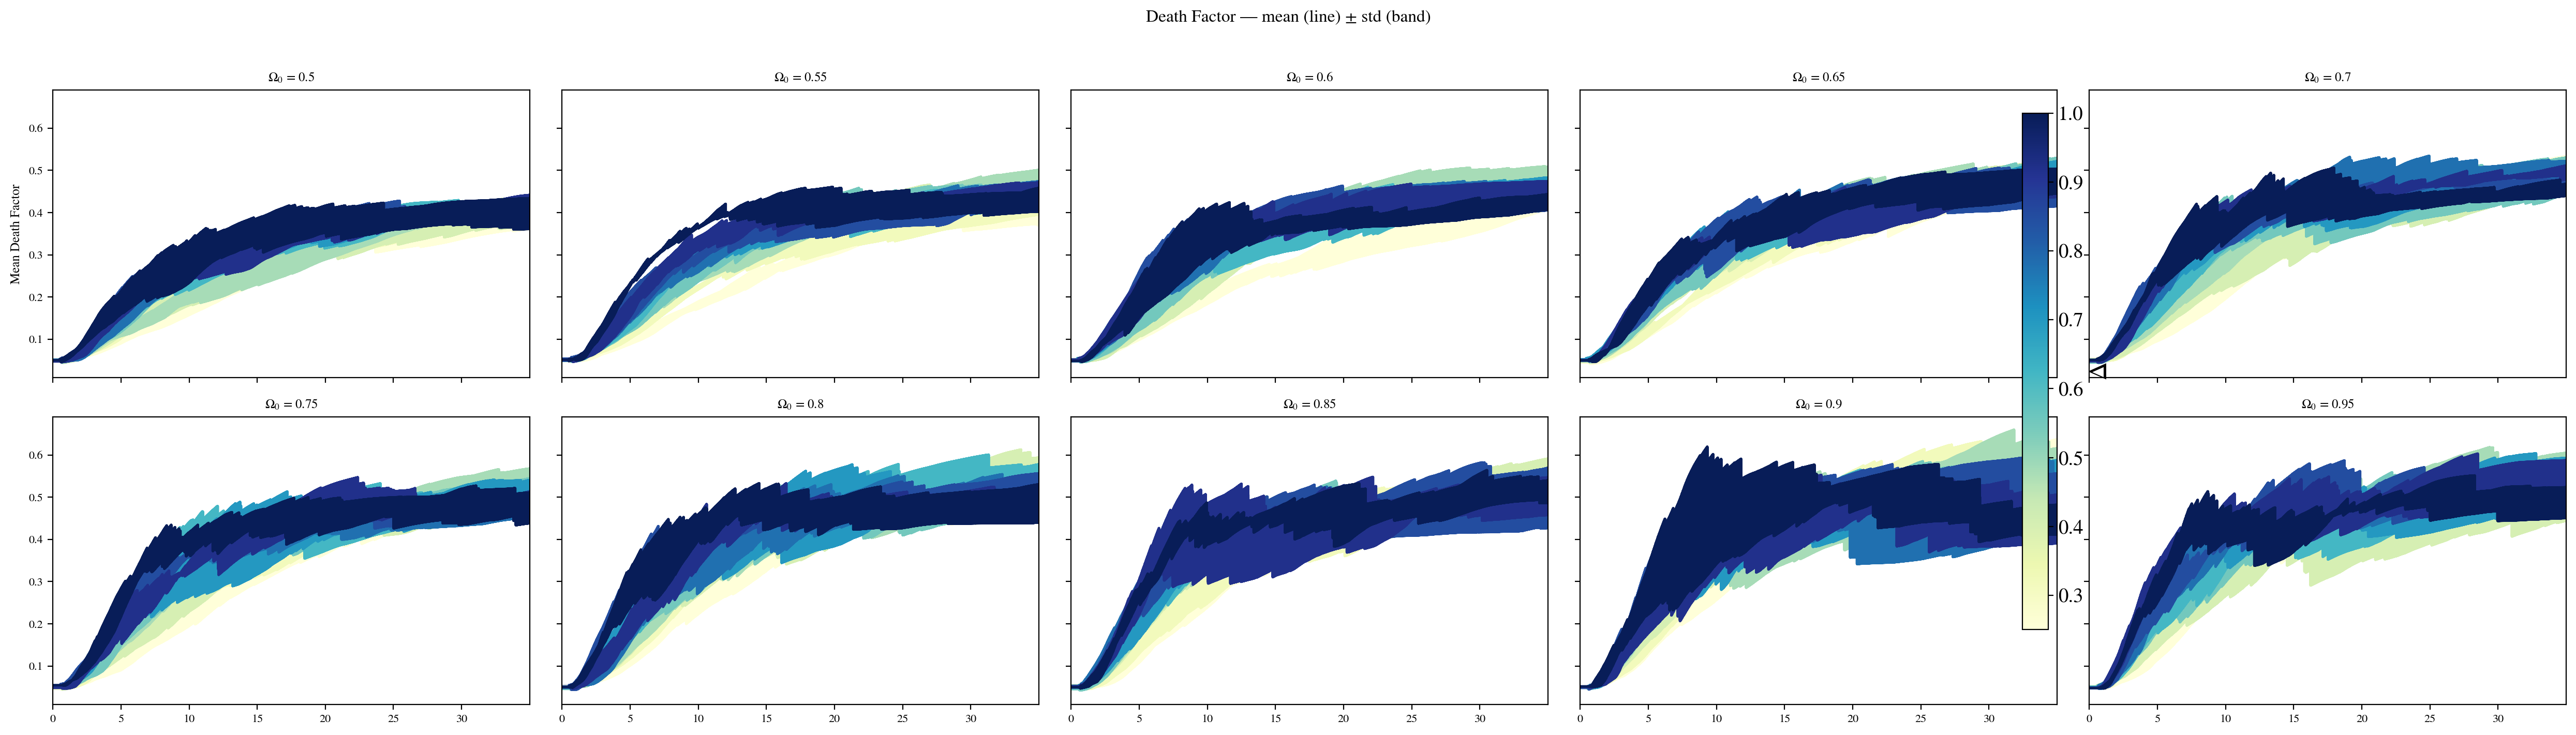

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_96310/59204661.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


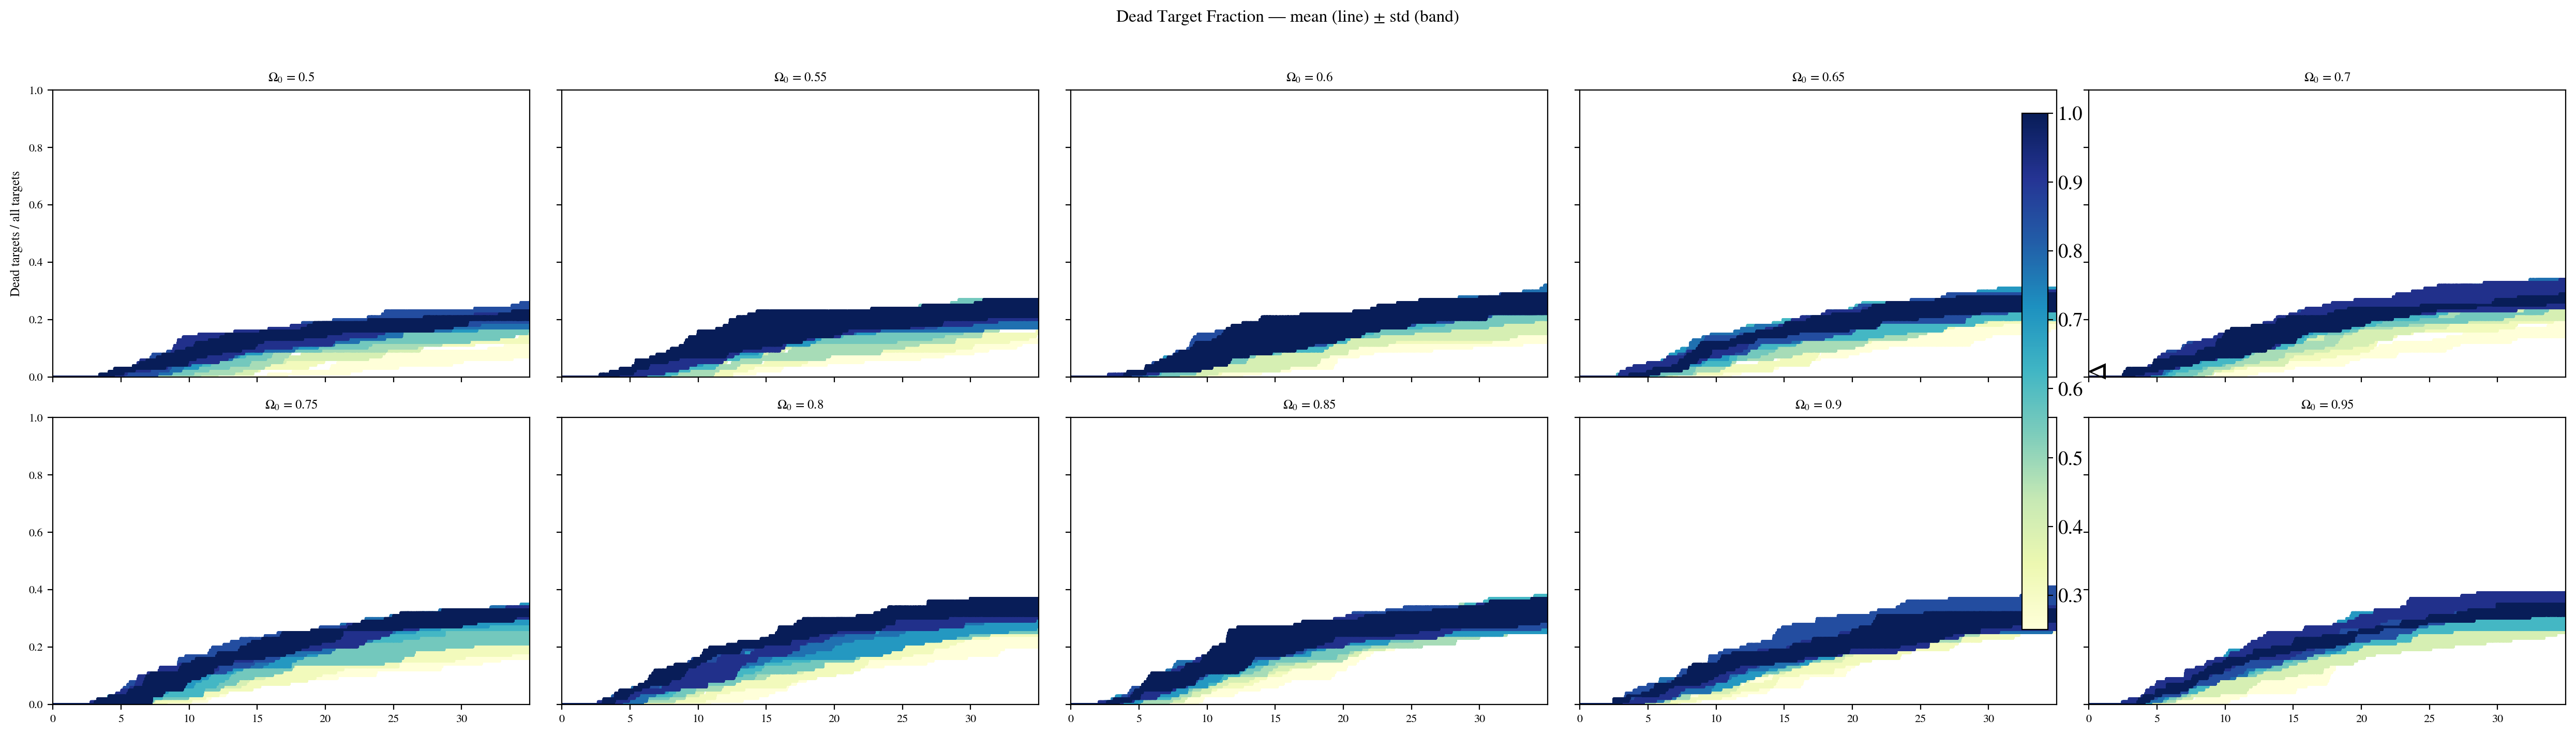

In [6]:
# helper to ensure numeric sort order
def _sorted_unique(a):
    vals = np.unique(a)
    try:
        return sorted(vals)
    except Exception:
        return list(vals)

# grid size: 2 rows x 5 cols (5 columns, 2 rows)
n_rows, n_cols = 2, 5
max_panels = n_rows * n_cols

# common plotting params
cmap = get_cmap("YlGnBu")

# ---------- 1) Mean Death Factor with mean line + std band ----------
dft = df_eps[df_eps["cell_type"] == "target"].copy()

agg_df = (
    dft.groupby(["omg0", "del", "rep", "time"])["Death_Factor"].mean().reset_index()
    .groupby(["omg0", "del", "time"])["Death_Factor"].agg(["mean", "std"]).reset_index()
)

omega_vals = _sorted_unique(agg_df["omg0"])
omega_vals = omega_vals[:max_panels]  # limit to 10 panels
delta_vals = _sorted_unique(agg_df["del"])
norm = Normalize(vmin=min(delta_vals), vmax=max(delta_vals))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.6 * n_rows), dpi=200, sharex=True, sharey=True)
axes_flat = axes.flatten()

for idx, ax in enumerate(axes_flat):
    if idx >= len(omega_vals):
        ax.set_visible(False)
        continue
    om = omega_vals[idx]
    sub = agg_df[agg_df["omg0"] == om]
    for de in delta_vals:
        cur = sub[sub["del"] == de].sort_values("time")
        if cur.empty:
            continue
        t = cur["time"].to_numpy()
        m = cur["mean"].to_numpy()
        s = cur["std"].fillna(0).to_numpy()
        color = cmap(norm(de))
        ax.plot(t, m, color=color, lw=1.8)
        if np.any(s > 0):
            ax.fill_between(t, m - s, m + s, color=color, alpha=0.22, linewidth=0)
    ax.set_title(fr"$\Omega_0$ = {om:.3g}", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.set_xlim(agg_df["time"].min(), agg_df["time"].max())
axes_flat[0].set_ylabel("Mean Death Factor", fontsize=9)

# colorbar for Δ
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes_flat.tolist(), label=r"$\Delta$", shrink=0.9, pad=0.02)
fig.suptitle("Death Factor — mean (line) ± std (band)", fontsize=12, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ---------- 2) Dead-target proportion (mean line + std band) ----------
per_rep = (
    dft.groupby(["omg0", "del", "rep", "time"])["alive_status"]
       .apply(lambda s: (~s.astype(bool)).mean())
       .rename("dead_prop")
       .reset_index()
)

agg_prop = (
    per_rep.groupby(["omg0", "del", "time"])["dead_prop"]
           .agg(["mean", "std"])
           .reset_index()
)

omega_vals = _sorted_unique(agg_prop["omg0"])
omega_vals = omega_vals[:max_panels]
delta_vals = _sorted_unique(agg_prop["del"])
norm = Normalize(vmin=min(delta_vals), vmax=max(delta_vals))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.6 * n_rows), dpi=200, sharex=True, sharey=True)
axes_flat = axes.flatten()

for idx, ax in enumerate(axes_flat):
    if idx >= len(omega_vals):
        ax.set_visible(False)
        continue
    om = omega_vals[idx]
    sub = agg_prop[agg_prop["omg0"] == om]
    for de in delta_vals:
        cur = sub[sub["del"] == de].sort_values("time")
        if cur.empty:
            continue
        t = cur["time"].to_numpy()
        m = cur["mean"].to_numpy()
        s = cur["std"].fillna(0).to_numpy()
        color = cmap(norm(de))
        ax.plot(t, m, color=color, lw=1.8)
        if np.any(s > 0):
            ax.fill_between(t, m - s, m + s, color=color, alpha=0.22, linewidth=0)
    ax.set_title(fr"$\Omega_0$ = {om:.3g}", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.set_xlim(agg_prop["time"].min(), agg_prop["time"].max())
    ax.set_ylim(0, 1)
axes_flat[0].set_ylabel("Dead targets / all targets", fontsize=9)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes_flat.tolist(), label=r"$\Delta$", shrink=0.9, pad=0.02)
fig.suptitle("Dead Target Fraction — mean (line) ± std (band)", fontsize=12, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

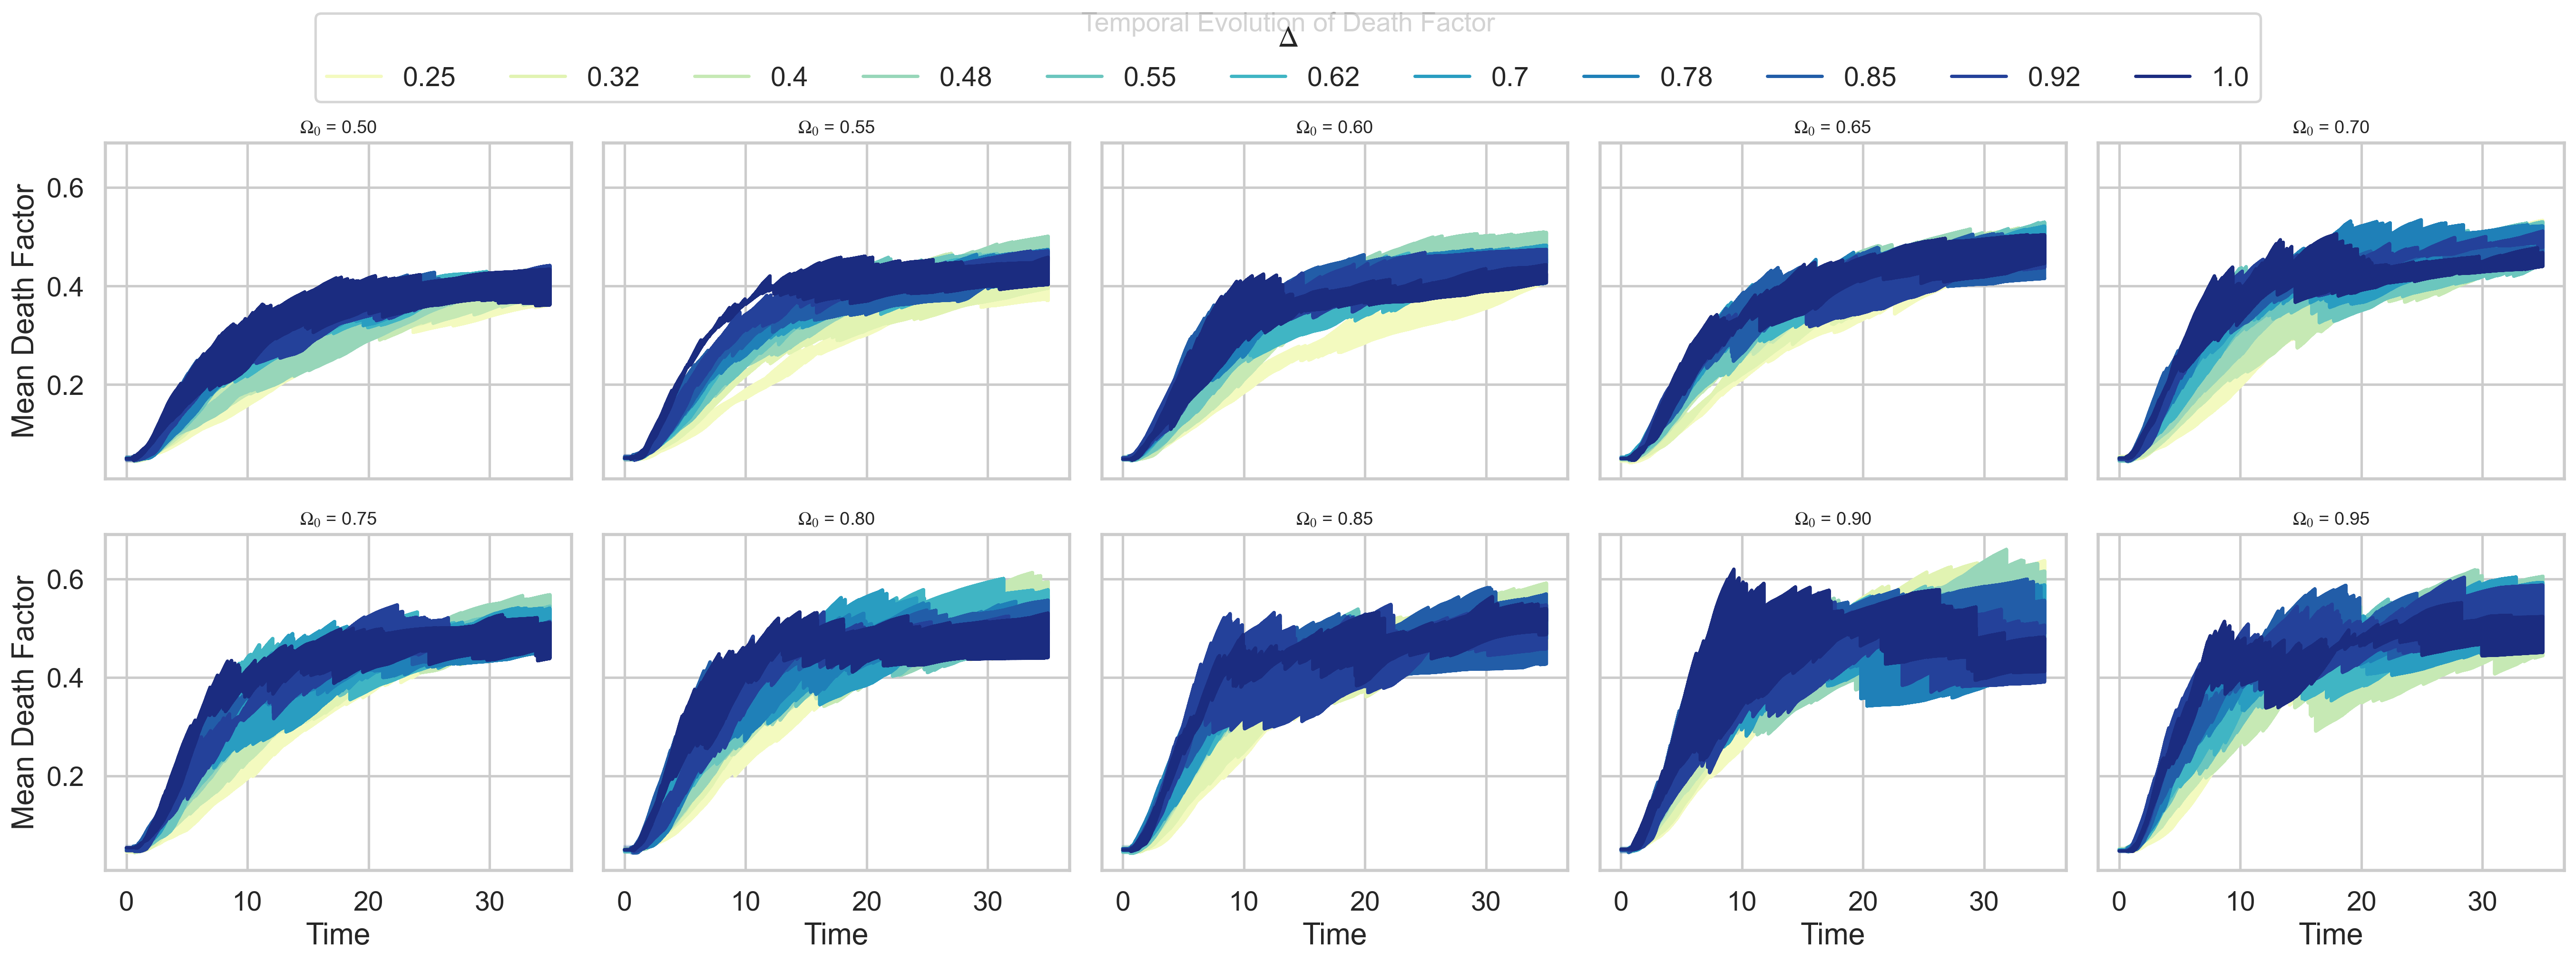

In [ ]:
sns.set_theme(style="whitegrid", context="talk")

# ---------- 1) Death Factor ----------
dft = df_eps[df_eps["cell_type"] == "target"].copy()

# Average across replicates per (Ω₀, Δ, time)
mean_df = (
    dft.groupby(["omg0", "del", "rep", "time"])["Death_Factor"].mean().reset_index()
)

omega_vals = sorted(mean_df["omg0"].unique())
delta_vals = sorted(mean_df["del"].unique())

n_rows, n_cols = 2, 5s
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 8), dpi=250, sharex=True, sharey=True)
axes = axes.flatten()

palette = sns.color_palette("YlGnBu", n_colors=len(delta_vals))

for ax, om in zip(axes, omega_vals):
    sub = mean_df[mean_df["omg0"] == om]
    sns.lineplot(
        data=sub,
        x="time", y="Death_Factor",
        hue="del",
        palette=palette,
        errorbar="sd",  # standard deviation shading
        ax=ax,
        lw=2
    )
    ax.set_title(fr"$\Omega_0$ = {om:.2f}", fontsize=11)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Death Factor")
    ax.legend_.remove()

for ax in axes[len(omega_vals):]:
    ax.set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title=r"$\Delta$", loc="upper center", ncol=len(delta_vals))
fig.suptitle("Temporal Evolution of Death Factor", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_82640/3897504820.py:66: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  plt.tight_layout(rect=(0.04, 0.04, 1, 0.98))
/Users/marsian/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  fig.canvas.print_figure(bytes_io, **kw)


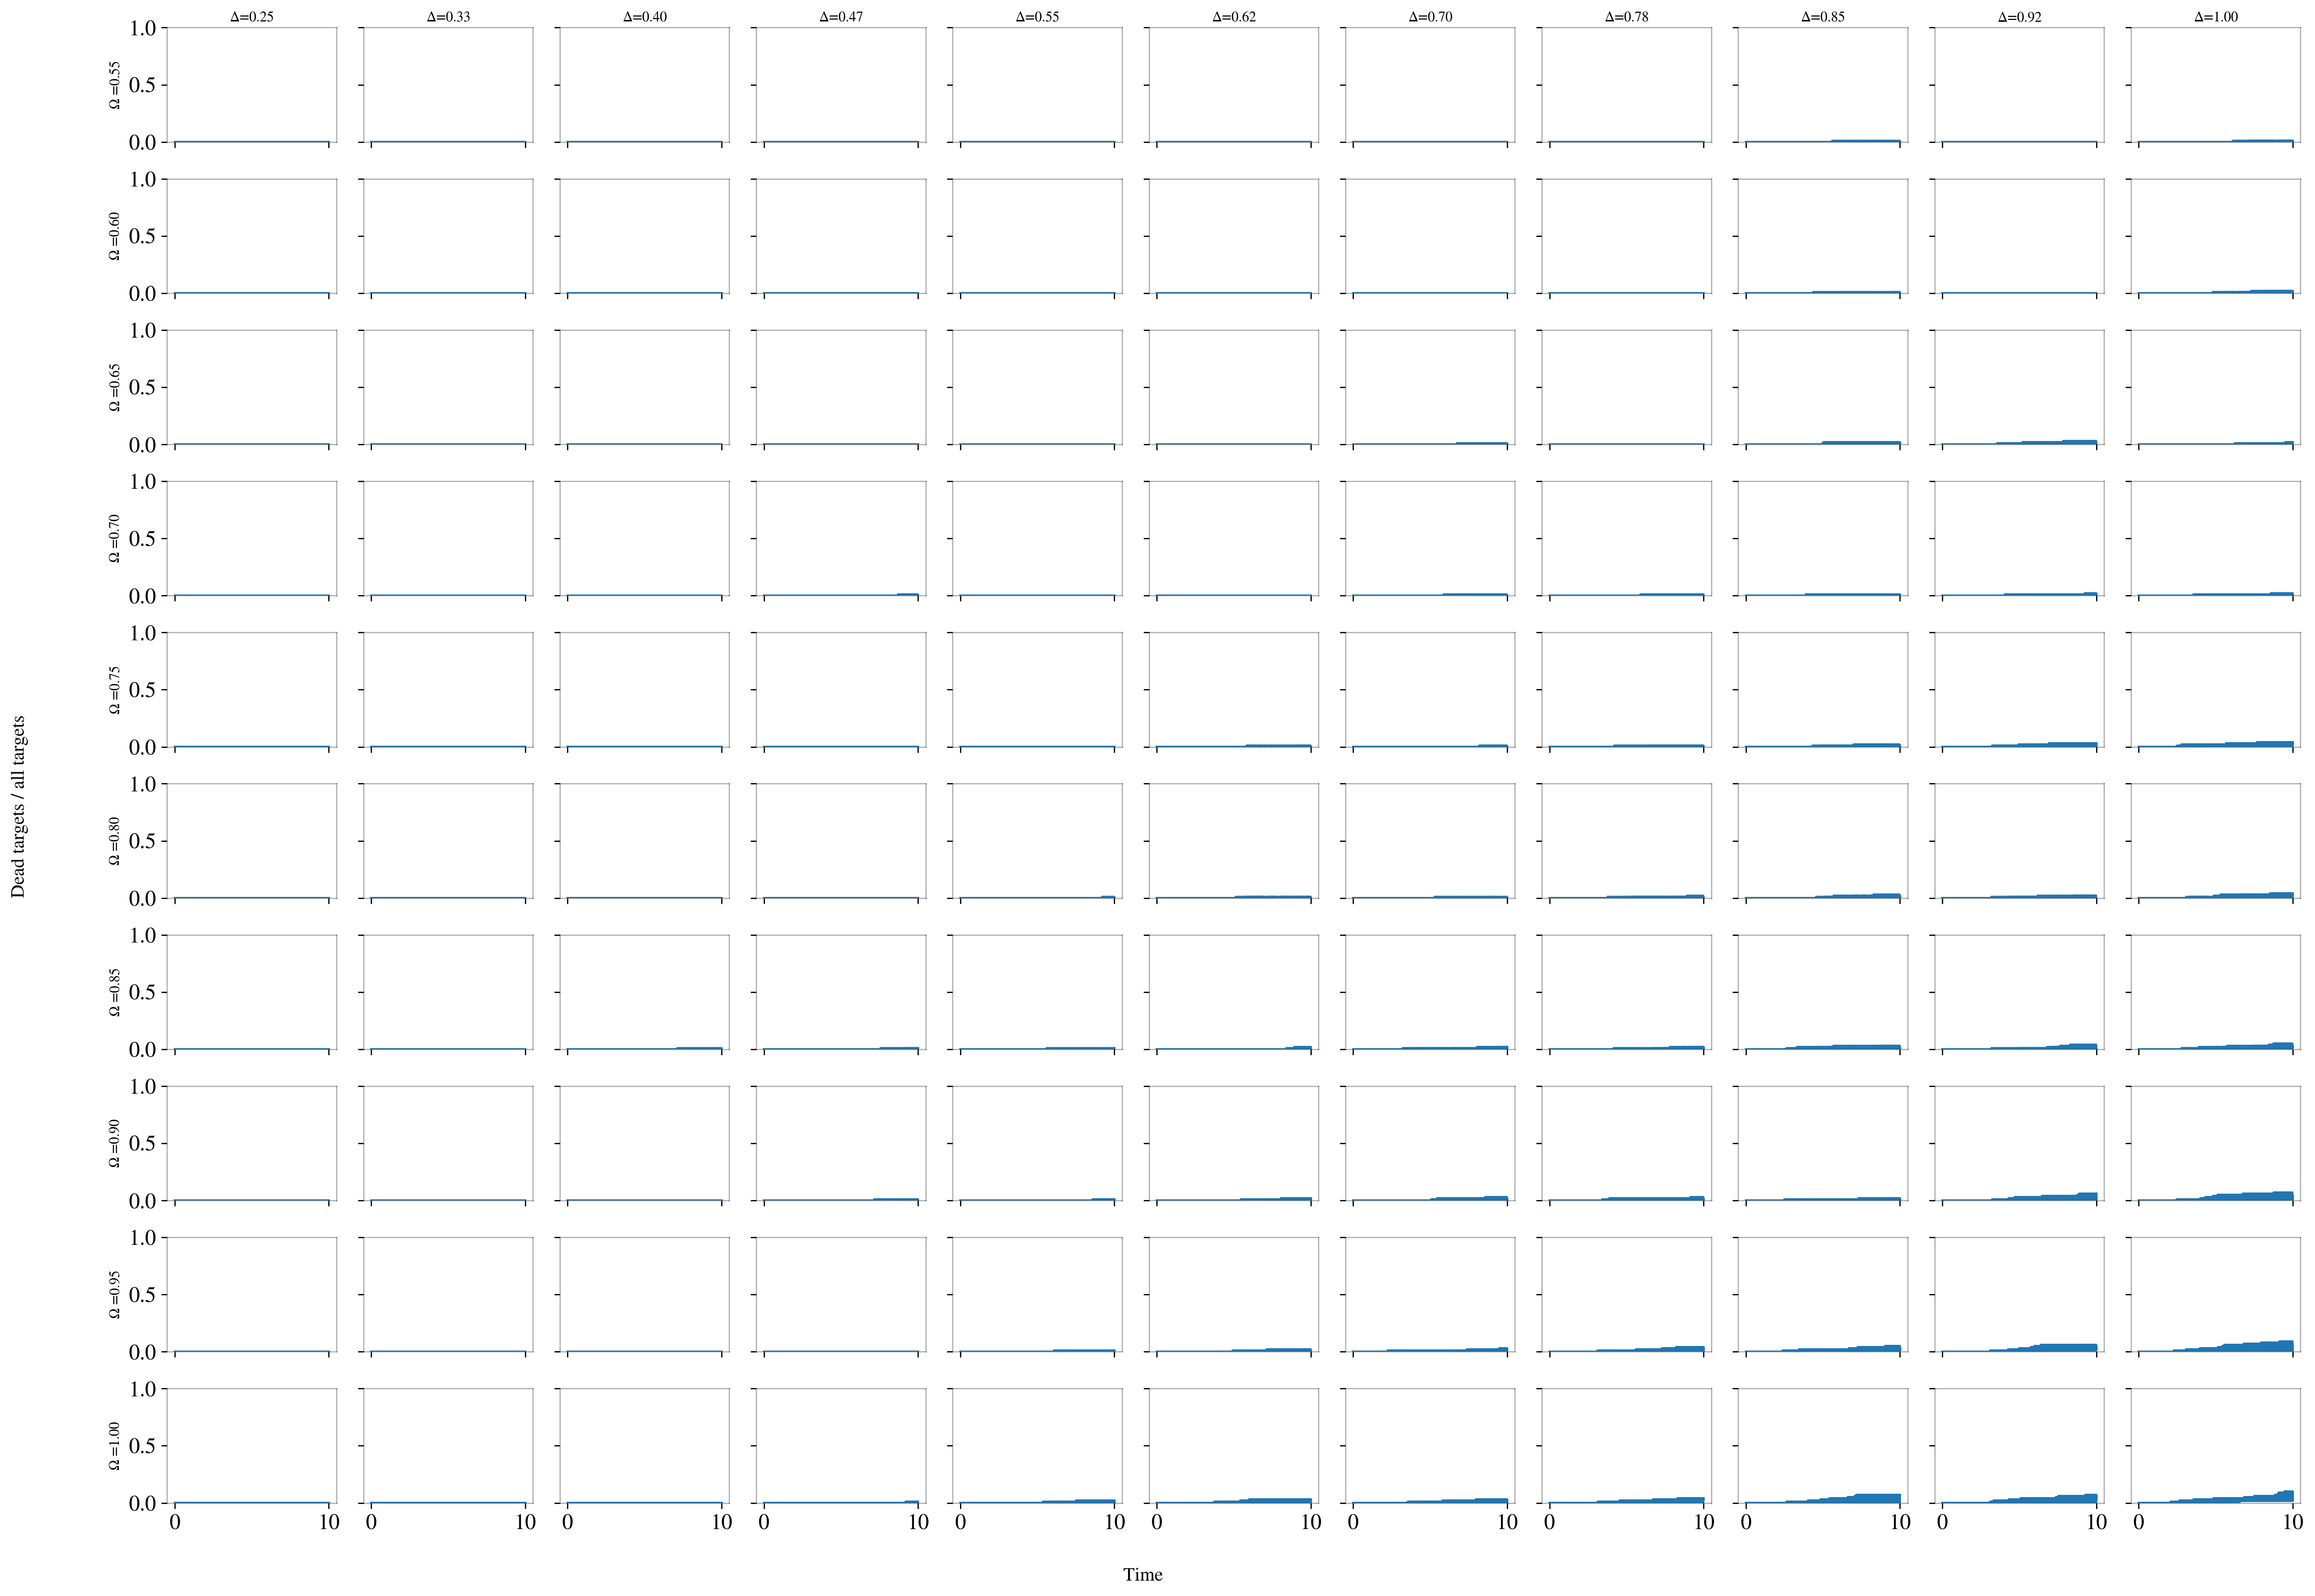

In [13]:
# --- 0) keep only target rows
dft = df[df["cell_type"] == "target"].copy()

# --- 1) per replicate & time: proportion of dead targets
per_rep = (
    dft.groupby(["omega0", "delta", "replicate", "time"])["alive_status"]
       .apply(lambda s: (~s.astype(bool)).mean())  # fraction dead in that replicate at that time
       .rename("dead_prop")
       .reset_index()
)

# --- 2) aggregate across replicates: mean & std at each (omega0, delta, time)
agg = (
    per_rep.groupby(["omega0", "delta", "time"])["dead_prop"]
           .agg(mean="mean", std="std")
           .reset_index()
)

# --- 3) grid axes: rows=omega0, cols=delta
omega_vals = sorted(agg["omega0"].unique())
delta_vals = sorted(agg["delta"].unique())

nrows, ncols = len(omega_vals), len(delta_vals)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(1.9*ncols, 1.5*nrows), dpi=300, sharex=True, sharey=True
)
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

# --- 4) draw each tiny timeseries
for r, om in enumerate(omega_vals):
    for c, de in enumerate(delta_vals):
        ax = axes[r, c]
        cur = agg[(agg["omega0"] == om) & (agg["delta"] == de)].sort_values("time")
        if cur.empty:
            ax.axis("off")
            continue
        t = cur["time"].to_numpy()
        m = cur["mean"].to_numpy()
        s = cur["std"].fillna(0).to_numpy()

        ax.plot(t, m, lw=1.5, color="C0")
        if np.any(s > 0):
            ax.fill_between(t, m - s, m + s, color="C0", alpha=0.25, linewidth=0)

        # cosmetics
        ax.set_ylim(0, 1)
        ax.grid(False)
        for spine in ax.spines.values(): spine.set_alpha(0.3)

        # top row: column titles (Δ)
        if r == 0:
            ax.set_title(f"Δ={de:.2f}", fontsize=9, pad=4)
        # first col: row labels (Ω0)
        if c == 0:
            ax.set_ylabel(fr"Ω₀={om:.2f}", fontsize=9)

# common x/y labels
fig.supxlabel("Time", y=0.04)
fig.supylabel("Dead targets / all targets", x=0.02)

plt.tight_layout(rect=(0.04, 0.04, 1, 0.98))
plt.show()

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_82640/3607609762.py:69: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  plt.tight_layout(rect=(0.04, 0.04, 1, 0.98))
/Users/marsian/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  fig.canvas.print_figure(bytes_io, **kw)


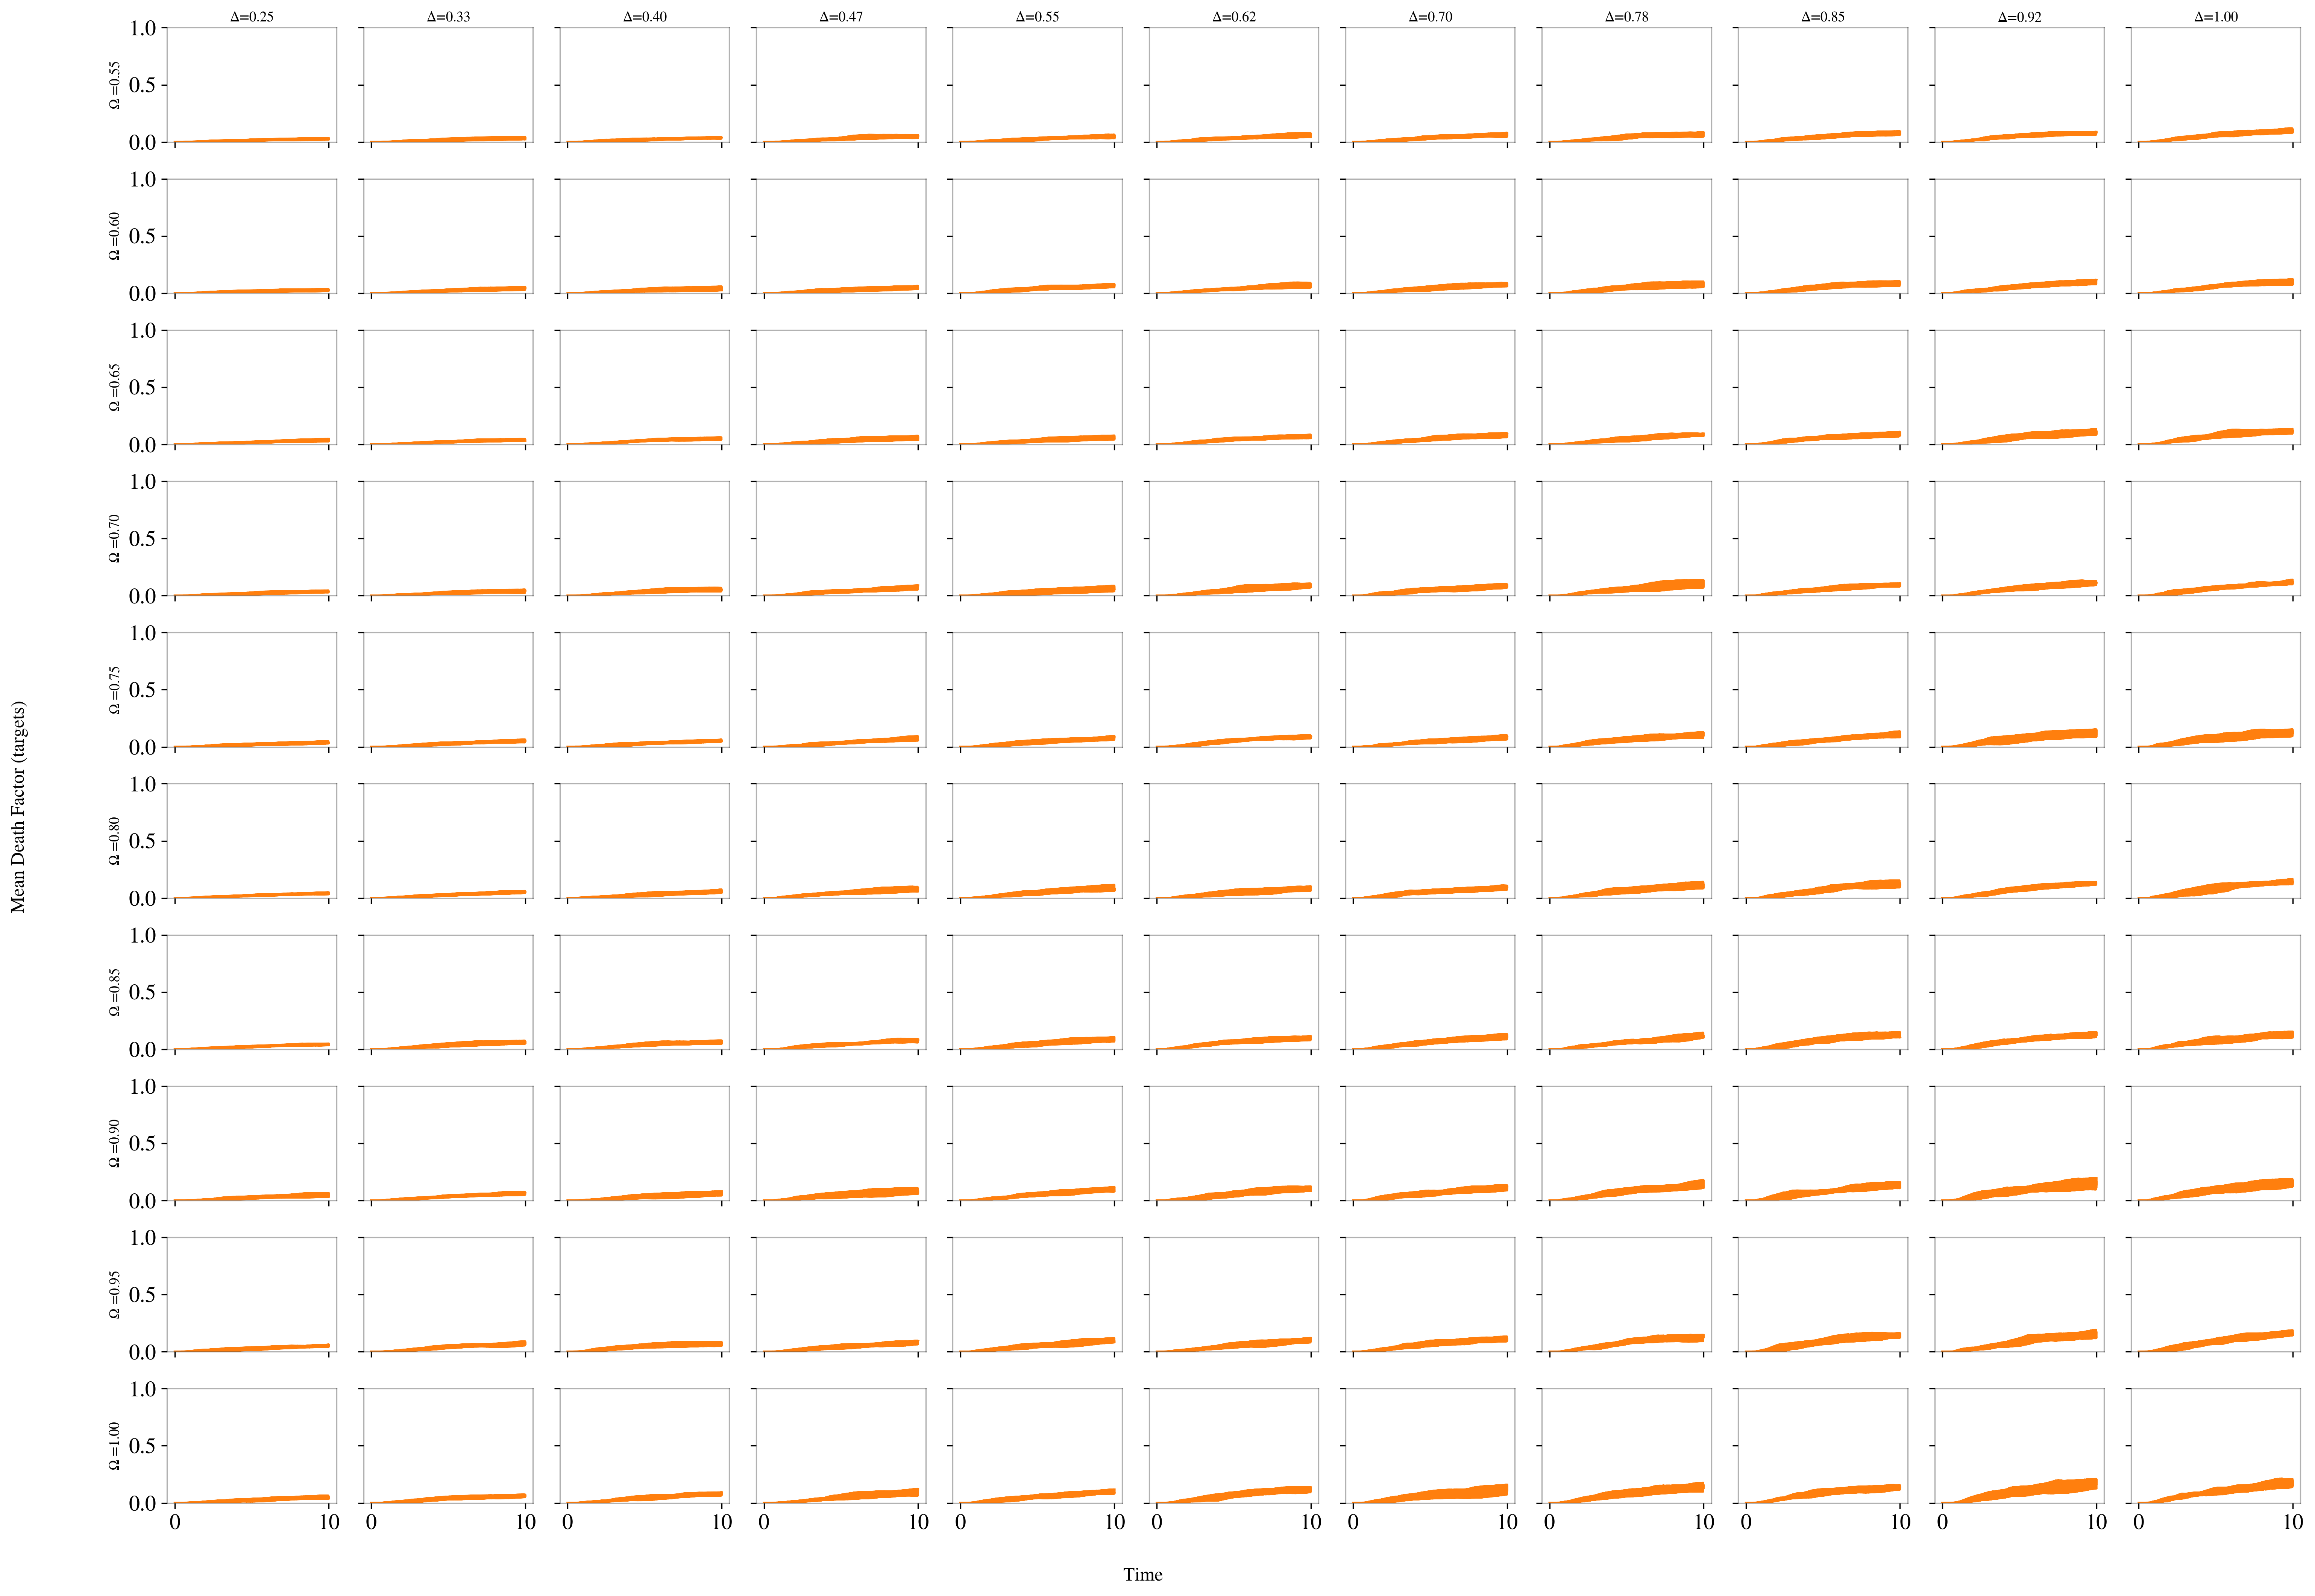

In [14]:
# --- 0) keep only target rows
dft = df[df["cell_type"] == "target"].copy()

# --- 1) per replicate & time: mean Death_Factor over all target cells
per_rep_df = (
    dft.groupby(["omega0", "delta", "replicate", "time"])["Death_Factor"]
       .mean()                         # average across targets in that replicate at that time
       .rename("df_mean_rep")
       .reset_index()
)

# --- 2) aggregate across replicates: mean & std at each (omega0, delta, time)
agg_df = (
    per_rep_df.groupby(["omega0", "delta", "time"])["df_mean_rep"]
              .agg(mean="mean", std="std")
              .reset_index()
)

# --- 3) grid axes: rows = omega0, cols = delta
omega_vals = sorted(agg_df["omega0"].unique())
delta_vals = sorted(agg_df["delta"].unique())

nrows, ncols = len(omega_vals), len(delta_vals)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(1.9*ncols, 1.5*nrows),
    dpi=300, sharex=True, sharey=True
)
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

# --- 4) draw each tiny timeseries
for r, om in enumerate(omega_vals):
    for c, de in enumerate(delta_vals):
        ax = axes[r, c]
        cur = agg_df[(agg_df["omega0"] == om) & (agg_df["delta"] == de)].sort_values("time")
        if cur.empty:
            ax.axis("off")
            continue

        t = cur["time"].to_numpy()
        m = cur["mean"].to_numpy()
        s = cur["std"].fillna(0).to_numpy()

        ax.plot(t, m, lw=1.5, color="C1")
        if np.any(s > 0):
            ax.fill_between(t, m - s, m + s, color="C1", alpha=0.25, linewidth=0)

        # cosmetics
        ax.set_ylim(0, 1)  # Death_Factor is capped at 1 in your sim
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_alpha(0.3)

        # top row titles (Δ)
        if r == 0:
            ax.set_title(f"Δ={de:.2f}", fontsize=9, pad=4)
        # first column y-labels (Ω0)
        if c == 0:
            ax.set_ylabel(fr"Ω₀={om:.2f}", fontsize=9)

# common labels
fig.supxlabel("Time", y=0.04)
fig.supylabel("Mean Death Factor (targets)", x=0.02)

plt.tight_layout(rect=(0.04, 0.04, 1, 0.98))
plt.show()

In [17]:
def extract_contact_durations(df):
    if df.empty:
        return []

    # sort frames by time (stable on step)
    df = df.sort_values(["time", "step"], kind="mergesort").reset_index(drop=True)

    def _to_list(x):
        if x is None or (isinstance(x, float) and np.isnan(x)): return []
        if isinstance(x, (list, tuple)): return list(x)
        if isinstance(x, str):
            s = x.strip()
            if not s or s.lower() == "nan": return []
            try:
                v = json.loads(s)
                return v if isinstance(v, list) else [v]
            except Exception:
                # fallback: split comma-delimited strings like "1,2,3"
                parts = [p.strip() for p in s.split(",") if p.strip()]
                return parts if parts else [s]
        return [x]

    def _pid(item):
        # int-like
        if isinstance(item, (int, np.integer)): return int(item)
        if isinstance(item, str) and item.isdigit(): return int(item)
        # dict-like
        if isinstance(item, dict):
            for k in ("id","cell_id","partner","partner_id"):
                if k in item:
                    try: return int(item[k])
                    except Exception: return None
            return None
        # list/tuple -> first element as id
        if isinstance(item, (list, tuple)) and len(item) >= 1:
            try: return int(item[0])
            except Exception: return None
        return None

    durations = []
    active = {}  # pair(tuple) -> start_time

    # iterate per unique time frame
    for t, frame in df.groupby("time", sort=True):
        t = float(t)
        # map id -> type to filter killer-target pairs
        id2type = frame.set_index("cell_id")["cell_type"].to_dict()

        # build set of unordered pairs present at this time
        pairs_now = set()
        for _, row in frame.iterrows():
            a_id = int(row["cell_id"])
            a_type = row["cell_type"]
            # candidate partners
            for it in _to_list(row.get("contacts", [])):
                b_id = _pid(it)
                if b_id is None: 
                    continue
                b_type = id2type.get(b_id)
                if b_type is None or b_type == a_type:
                    continue  # must be killer-target
                pair = (a_id, b_id) if a_id < b_id else (b_id, a_id)
                pairs_now.add(pair)

        # starts: in now, not in active
        for p in pairs_now.difference(active.keys()):
            active[p] = t

        # ends: in active, not in now
        for p in [p for p in active.keys() if p not in pairs_now]:
            start = active.pop(p)
            if t >= start:
                durations.append(t - start)

    # close any contacts still active at final time
    final_time = float(df["time"].iloc[-1])
    for p, start in list(active.items()):
        if final_time >= start:
            durations.append(final_time - start)
    active.clear()

    return durations

In [18]:
mean_contact_duration = {}
for (om, de), subdf in df.groupby(["omega0", "delta"]):
    print(f"Processing omega0={om}, delta={de}")
    duration_list_specific = []
    for i, subsubdf in df.groupby("replicate"):
        print(extract_contact_durations(subsubdf))
    

Processing omega0=0.5, delta=0.25
[0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.20000827884944117, 0.20000827884944117, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119, 0.10000827884944119,

KeyboardInterrupt: 

In [ ]:
# for (om, de), subdf in df.groupby(["omega0", "delta"]):

In [13]:
import json
import numpy as np
import pandas as pd

# ---------- helpers to make data consistent ----------

def _to_list(x):
    """Return a Python list for a contacts cell. Accept list, tuple, JSON string or NaN."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    if isinstance(x, str):
        s = x.strip()
        if s == "" or s.lower() == "nan":
            return []
        # try JSON
        try:
            v = json.loads(s)
            return v if isinstance(v, list) else [v]
        except Exception:
            # last resort: treat as single token
            return [s]
    # unknown object -> stringify
    return [str(x)]

def _extract_contact(item):
    """
    Try to extract (duration, lethal_flag) from one contact item.
    Accepts:
      - dict with keys 'duration' and optional 'lethal'/'killed'
      - list/tuple [*, duration, lethal?]
      - scalar -> returns (None, None)
    """
    # dict-like
    if isinstance(item, dict):
        dur = item.get("duration", item.get("dur", item.get("t", None)))
        lethal = item.get("lethal", item.get("killed", item.get("is_lethal", None)))
        try:
            dur = float(dur) if dur is not None else None
        except Exception:
            dur = None
        if isinstance(lethal, str):
            lethal = lethal.lower() in {"true", "1", "yes"}
        elif lethal is not None:
            lethal = bool(lethal)
        return dur, lethal

    # list/tuple
    if isinstance(item, (list, tuple)):
        if len(item) >= 2:
            dur = item[1]
            try:
                dur = float(dur)
            except Exception:
                dur = None
            lethal = None
            if len(item) >= 3:
                lethal = item[2]
                if isinstance(lethal, str):
                    lethal = lethal.lower() in {"true", "1", "yes"}
                else:
                    lethal = bool(lethal)
            return dur, lethal

    # everything else
    return None, None

# ---------- metric A & B: mean contact & mean lethal-contact durations ----------

def compute_contact_stats(df_one):
    """
    Given a DataFrame for one (omega0, delta, replicate) or any subset,
    return (mean_contact_duration, mean_lethal_contact_duration).
    Robust to many contact encodings; ignores rows without usable duration.
    """
    all_durs = []
    lethal_durs = []

    # we can use all rows, or restrict to targets if that's your convention:
    # rows = df_one[df_one.cell_type == "target"]
    rows = df_one

    for contacts_cell in rows["contacts"].apply(_to_list):
        for item in contacts_cell:
            dur, lethal = _extract_contact(item)
            if dur is None:
                continue
            all_durs.append(dur)
            if lethal is True:
                lethal_durs.append(dur)

    mean_contact = float(np.mean(all_durs)) if len(all_durs) else np.nan
    mean_lethal  = float(np.mean(lethal_durs)) if len(lethal_durs) else np.nan
    return mean_contact, mean_lethal

# ---------- metric C: average temporal evolution of Death_Factor ----------

def compute_deathfactor_evolution(df):
    """
    Return tidy table with mean Death_Factor per step, averaged over all cells.
    """
    return (
        df.groupby("step", as_index=False)["Death_Factor"]
          .mean()
          .rename(columns={"Death_Factor": "mean_deathfactor"})
    )

# ---------- metric D: time evolution of proportion of dead targets ----------

def compute_dead_prop_evolution(df):
    """
    Return tidy table with prop_dead per step = (# dead targets / # targets).
    A target is considered 'dead' if alive_status is False (or 0).
    """
    tdf = df[df["cell_type"] == "target"].copy()
    # Treat None/NaN as alive unless alive_status is explicitly False
    tdf["is_dead"] = ~tdf["alive_status"].astype(bool)
    return (
        tdf.groupby("step", as_index=False)["is_dead"]
           .mean()
           .rename(columns={"is_dead": "prop_dead"})
    )

# ---------- run across the whole grid ----------

def analyse_grid(df):
    """
    Returns a summary DataFrame with one row per (omega0, delta, replicate),
    plus two tidy time-series tables averaged across replicates:
      - deathfactor_ts (omega0, delta, step, mean_deathfactor)
      - deadprop_ts    (omega0, delta, step, prop_dead)
    """
    rows = []
    deathfactor_ts = []
    deadprop_ts = []

    # iterate per (omega0, delta, replicate)
    for (o, d, r), sdf in df.groupby(["omega0", "delta", "replicate"], sort=True):
        mean_contact, mean_lethal = compute_contact_stats(sdf)
        deathfactor_evo = compute_deathfactor_evolution(sdf)
        deathfactor_evo.insert(0, "omega0", o)
        deathfactor_evo.insert(1, "delta", d)
        deathfactor_evo.insert(2, "replicate", r)
        deathfactor_ts.append(deathfactor_evo)

        deadprop_evo = compute_dead_prop_evolution(sdf)
        deadprop_evo.insert(0, "omega0", o)
        deadprop_evo.insert(1, "delta", d)
        deadprop_evo.insert(2, "replicate", r)
        deadprop_ts.append(deadprop_evo)

        rows.append({
            "omega0": o, "delta": d, "replicate": r,
            "mean_contact": mean_contact,
            "mean_lethal":  mean_lethal,
        })

    agg = pd.DataFrame(rows)

    # also compute replicate-AVERAGED time series per (omega0, delta)
    df_deathfactor = (
        pd.concat(deathfactor_ts, ignore_index=True)
          .groupby(["omega0","delta","step"], as_index=False)["mean_deathfactor"].mean()
    )
    df_deadprop = (
        pd.concat(deadprop_ts, ignore_index=True)
          .groupby(["omega0","delta","step"], as_index=False)["prop_dead"].mean()
    )
    return agg, df_deathfactor, df_deadprop

# ---- run analysis on your df ----
agg_grid, deathfactor_ts, deadprop_ts = analyse_grid(df)

# quick peek:
agg_grid.head(), deathfactor_ts.head(), deadprop_ts.head()

(   omega0  delta  replicate  mean_contact  mean_lethal
 0     0.5   0.25          0           NaN          NaN
 1     0.5   0.25          1           NaN          NaN
 2     0.5   0.25          2           NaN          NaN
 3     0.5   0.25          3           NaN          NaN
 4     0.5   0.25          4           NaN          NaN,
    omega0  delta  step  mean_deathfactor
 0     0.5   0.25     0          0.000000
 1     0.5   0.25     1          0.000000
 2     0.5   0.25     2          0.000000
 3     0.5   0.25     3          0.000010
 4     0.5   0.25     4          0.000075,
    omega0  delta  step  prop_dead
 0     0.5   0.25     0        0.0
 1     0.5   0.25     1        0.0
 2     0.5   0.25     2        0.0
 3     0.5   0.25     3        0.0
 4     0.5   0.25     4        0.0)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


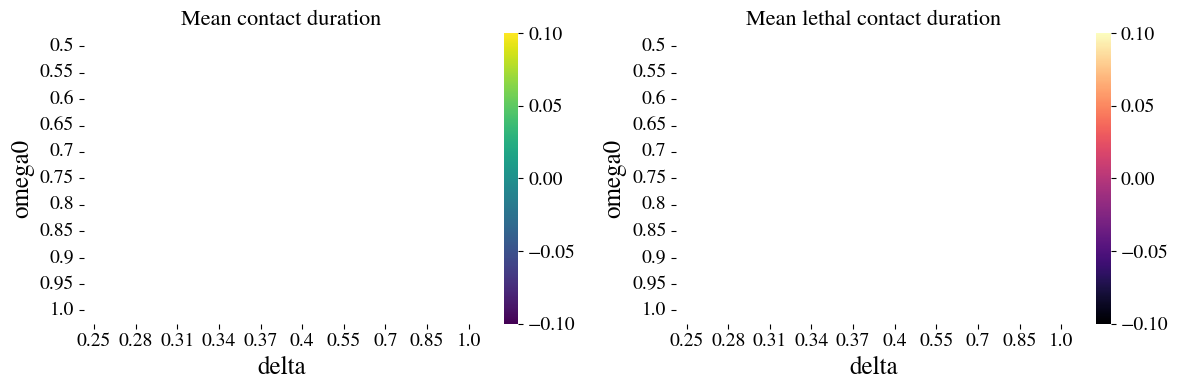

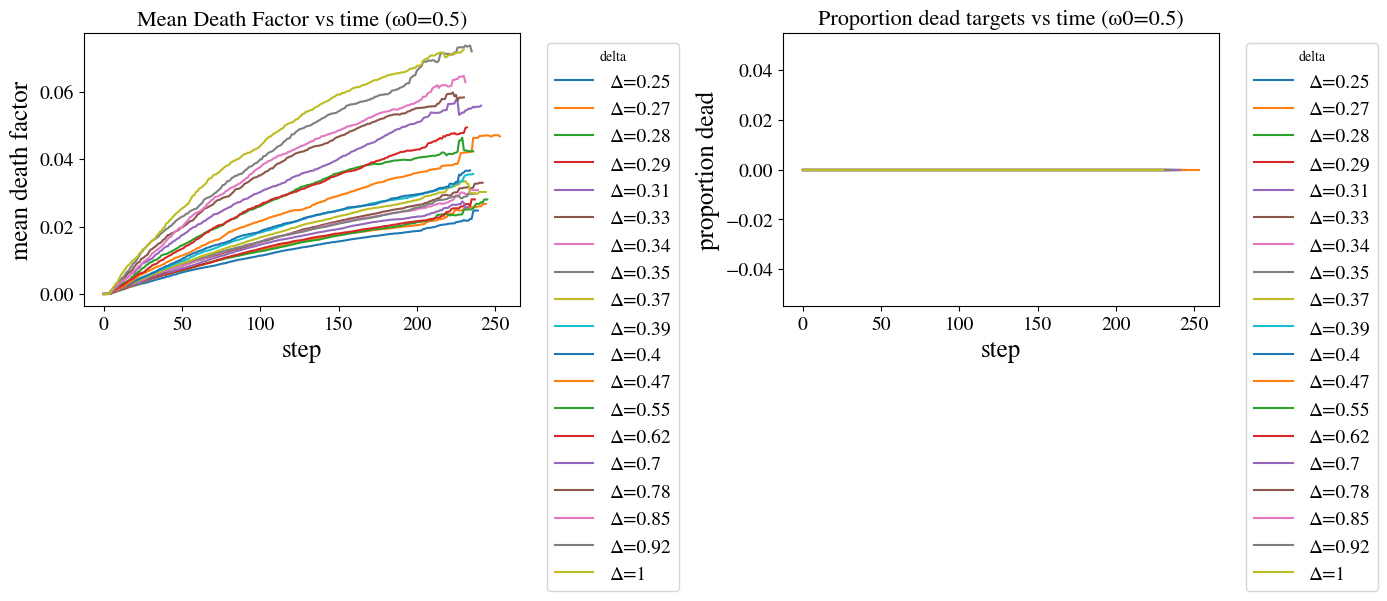

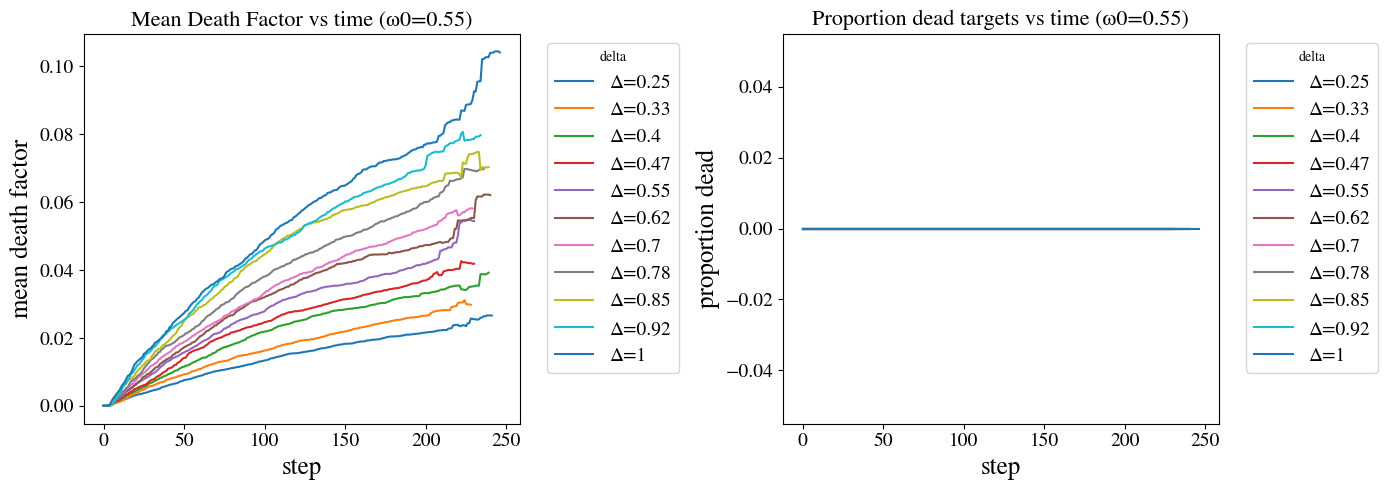

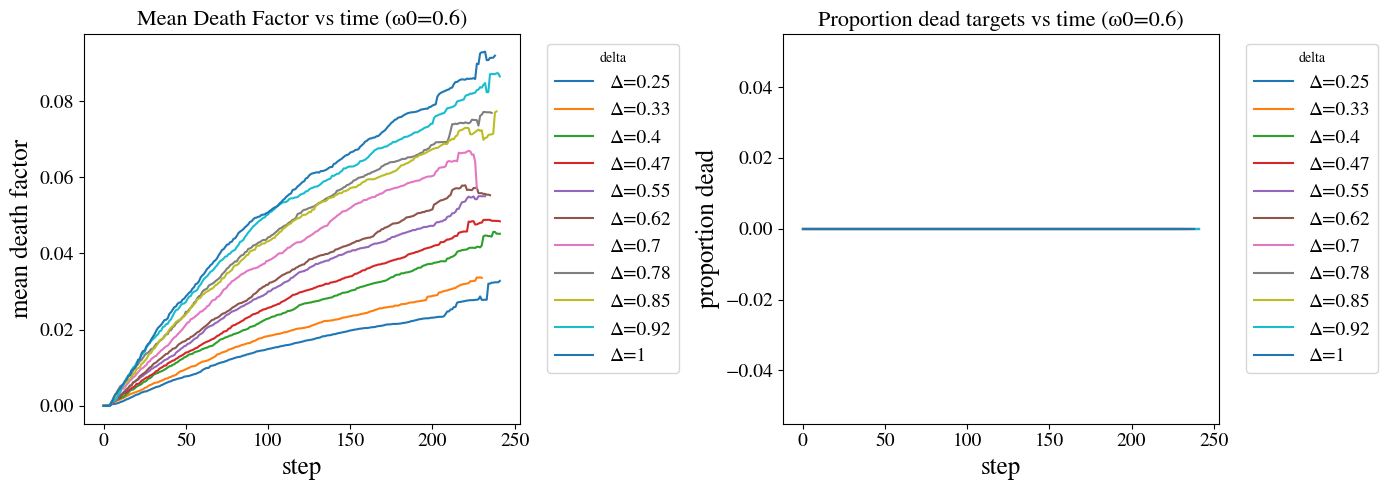

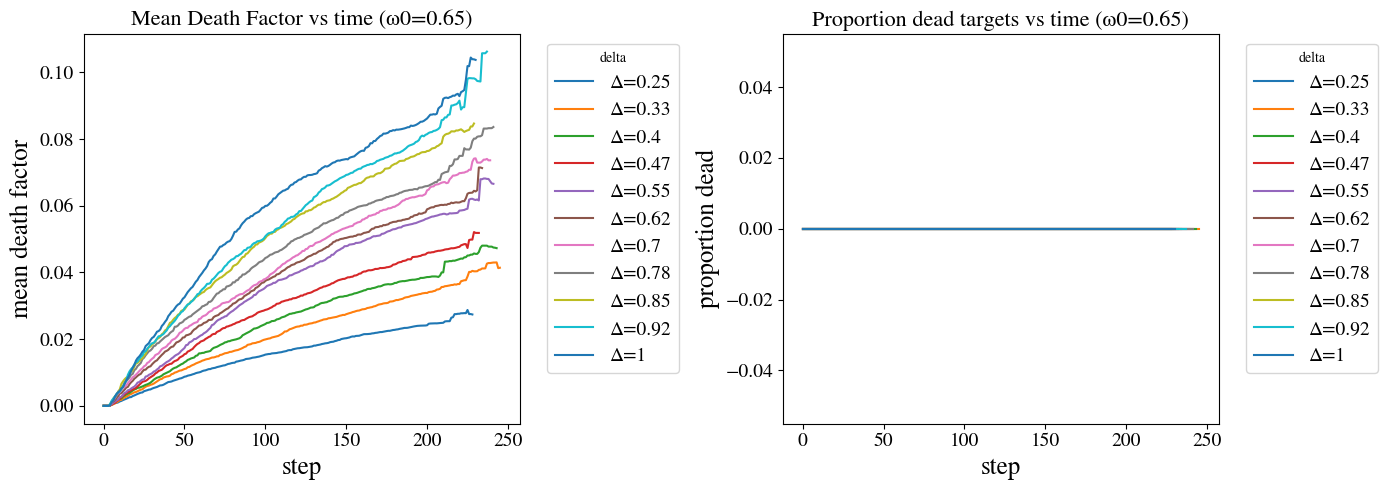

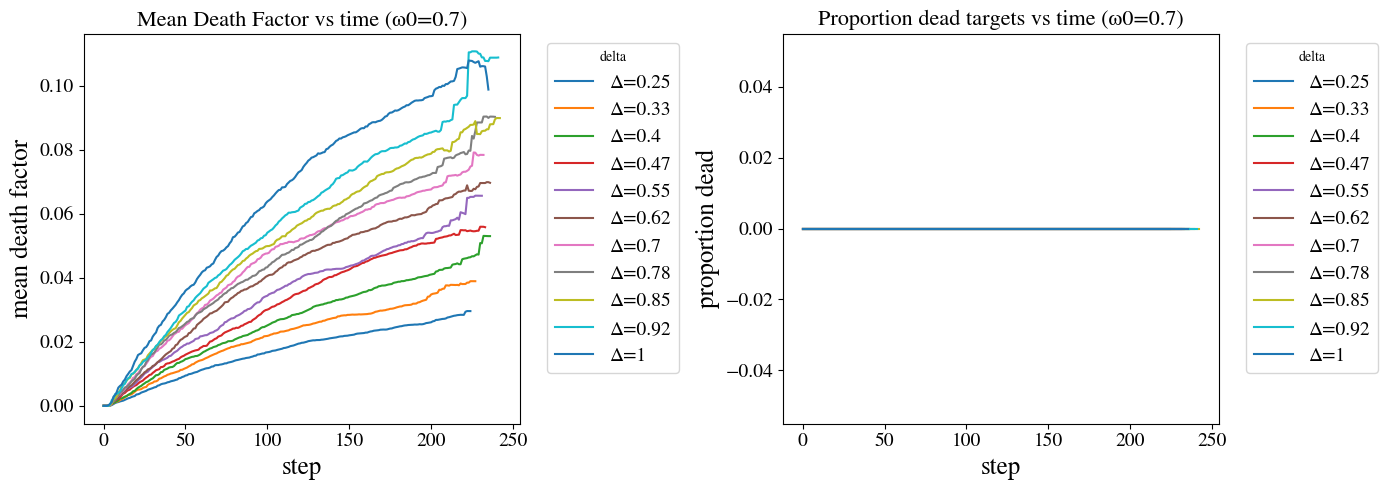

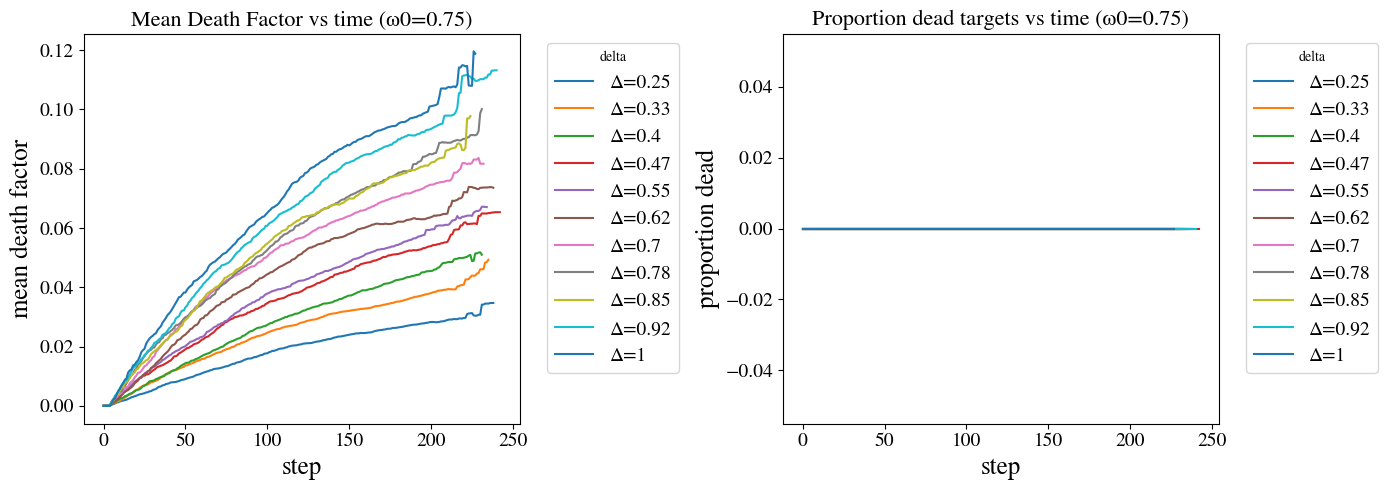

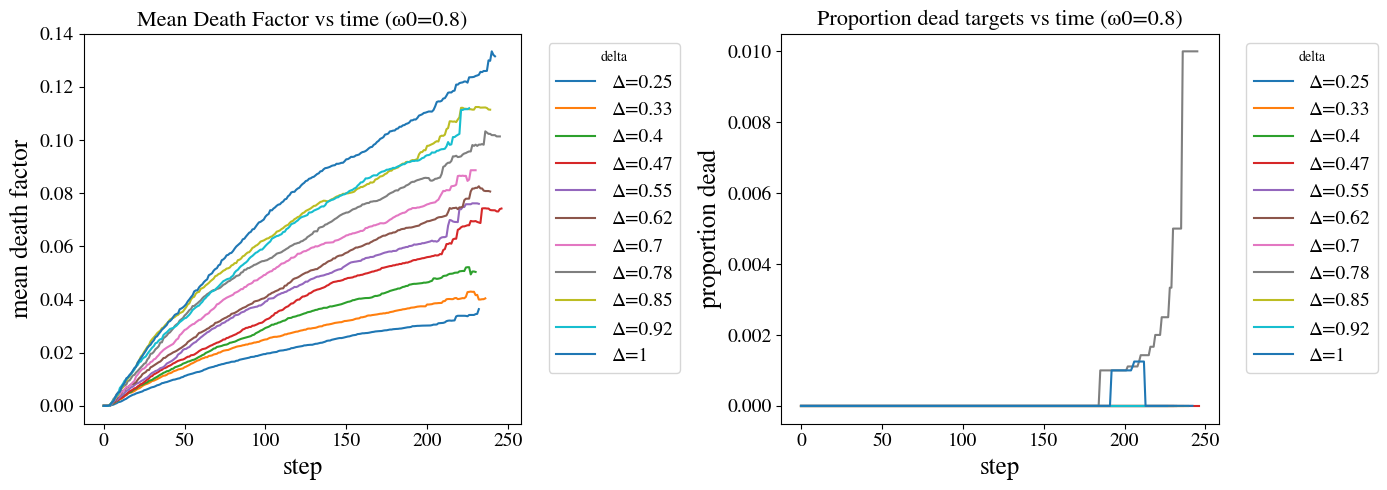

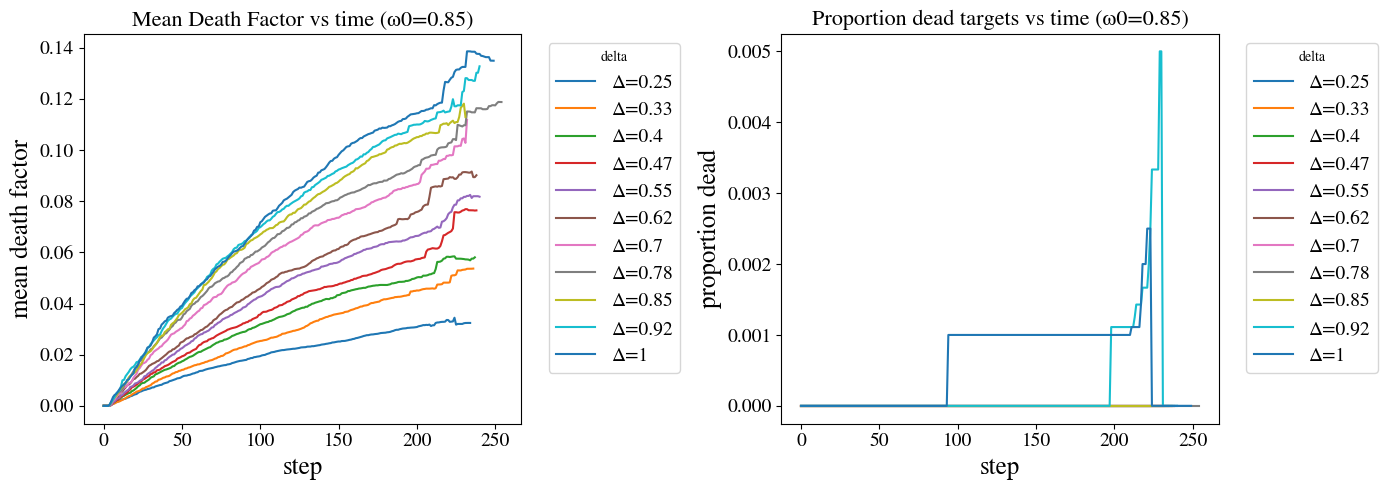

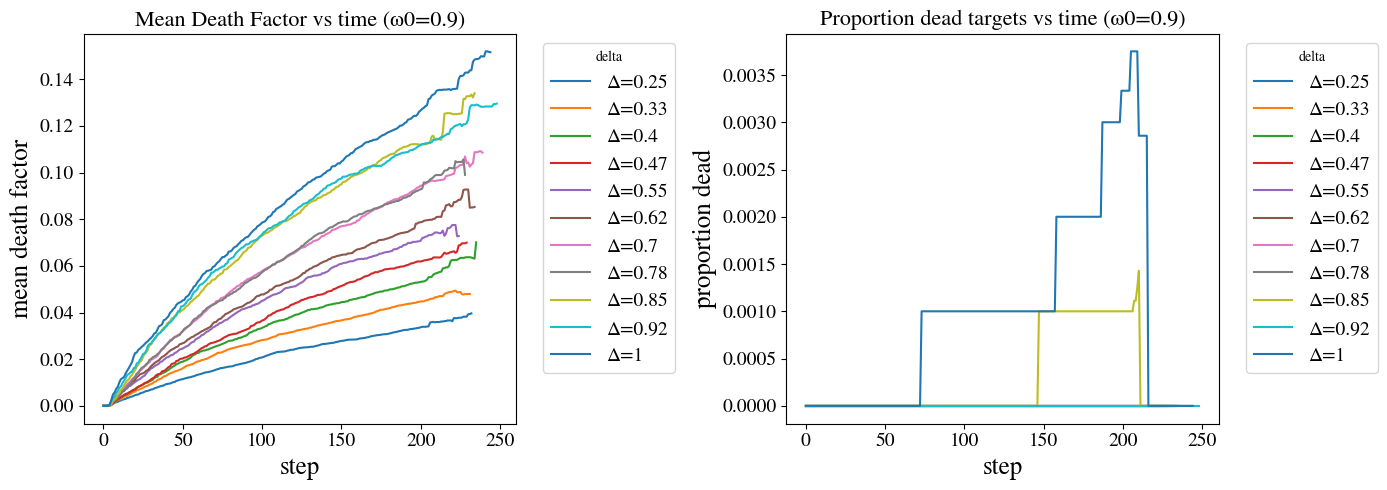

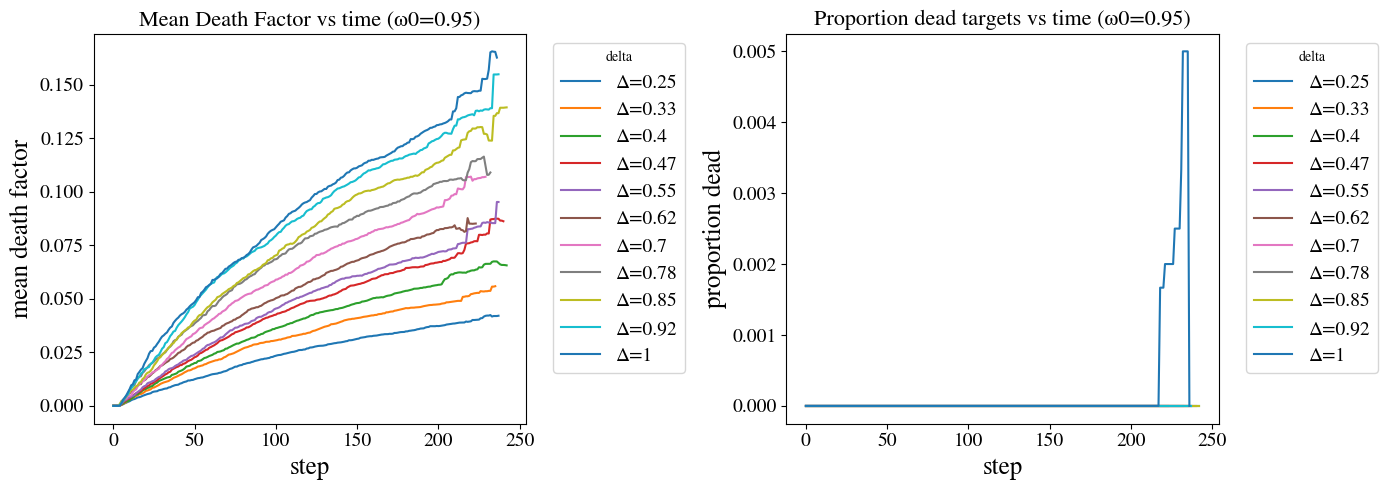

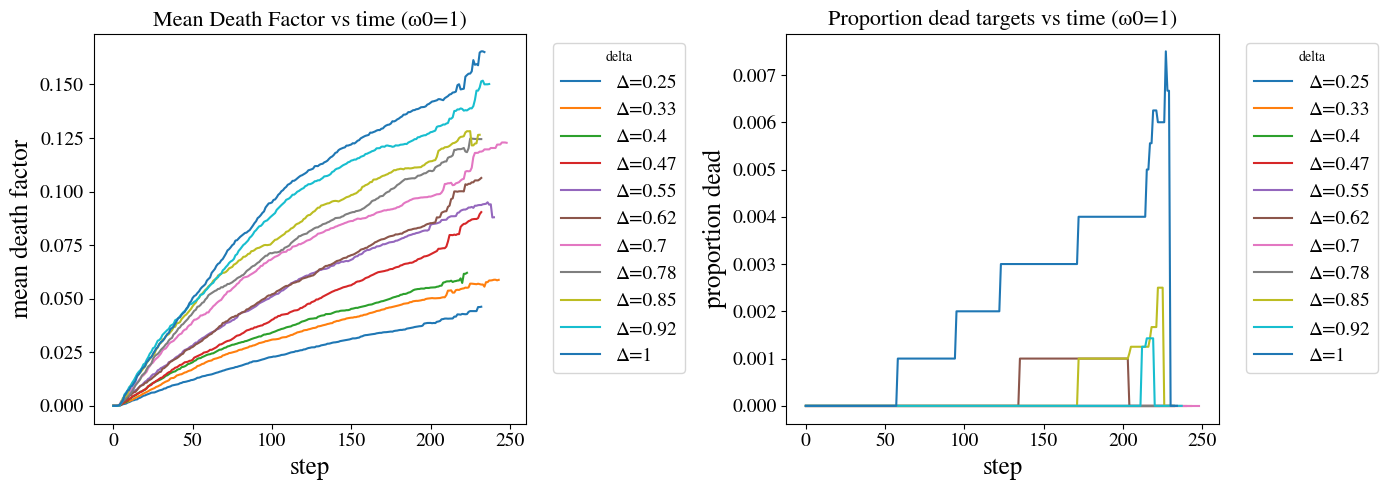

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- A/B: heatmaps over (omega0, delta) ----------

def plot_contact_heatmaps(agg_grid):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    pivot1 = agg_grid.groupby(["omega0","delta"])["mean_contact"].mean().unstack()
    sns.heatmap(pivot1, cmap="viridis")
    plt.title("Mean contact duration")
    plt.xlabel("delta"); plt.ylabel("omega0")

    plt.subplot(1,2,2)
    pivot2 = agg_grid.groupby(["omega0","delta"])["mean_lethal"].mean().unstack()
    sns.heatmap(pivot2, cmap="magma")
    plt.title("Mean lethal contact duration")
    plt.xlabel("delta"); plt.ylabel("omega0")

    plt.tight_layout()
    plt.show()

# ---------- C/D: temporal evolution for all delta at a fixed omega0 ----------

def plot_temporal_panels(deathfactor_ts, deadprop_ts, omega0_value):
    df_df = deathfactor_ts[deathfactor_ts["omega0"] == omega0_value]
    df_dp = deadprop_ts[deadprop_ts["omega0"] == omega0_value]

    deltas = sorted(df_df["delta"].unique())

    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True)
    for d in deltas:
        sub_df = df_df[df_df["delta"] == d]
        axes[0].plot(sub_df["step"], sub_df["mean_deathfactor"], label=f"Δ={d:g}")
    axes[0].set_title(f"Mean Death Factor vs time (ω0={omega0_value:g})")
    axes[0].set_xlabel("step"); axes[0].set_ylabel("mean death factor")

    for d in deltas:
        sub_dp = df_dp[df_dp["delta"] == d]
        axes[1].plot(sub_dp["step"], sub_dp["prop_dead"], label=f"Δ={d:g}")
    axes[1].set_title(f"Proportion dead targets vs time (ω0={omega0_value:g})")
    axes[1].set_xlabel("step"); axes[1].set_ylabel("proportion dead")

    axes[0].legend(title="delta", bbox_to_anchor=(1.04, 1), loc="upper left")
    axes[1].legend(title="delta", bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ---- draw the figures ----
plot_contact_heatmaps(agg_grid)

for o in sorted(agg_grid["omega0"].unique()):
    plot_temporal_panels(deathfactor_ts, deadprop_ts, omega0_value=o)

In [12]:
results = analyse_grid(df)

ValueError: not enough values to unpack (expected 3, got 1)